In [ ]:
# Install Required Packages
!pip install scikit-optimize==0.10.2 xgboost==2.1.1 numpy==2.0.0 pandas==2.2.2 scikit-learn==1.5.1 matplotlib==3.9.1

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Validation
from sklearn.model_selection import KFold, LeaveOneOut

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Tree-based models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Support Vector Machines
from sklearn.svm import SVR

# Gaussian Process
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# XGBoost
from xgboost import XGBRegressor

# Skopt (scikit-optimize)
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Permutation feature importance
from sklearn.inspection import permutation_importance

# Cloning
from sklearn.base import clone

# Multi-output regressors
from sklearn.multioutput import MultiOutputRegressor

# Pipelines
from sklearn.pipeline import Pipeline, make_pipeline


Model Performance Metrics for Calculated_Band_Gap/eV (sorted by Test MSE):
XGBoost:
  Average Train Metrics - MSE = 0.00, RMSE = 0.01, MAE = 0.01, R2 = 1.00
  Average Test Metrics - MSE = 0.01, RMSE = 0.10, MAE = 0.04, R2 = 0.99
  Best Fold Train Metrics - MSE = 0.00, RMSE = 0.01, MAE = 0.01, R2 = 1.00
  Best Fold Test Metrics - MSE = 0.01, RMSE = 0.08, MAE = 0.04, R2 = 1.00

Gaussian Process:
  Average Train Metrics - MSE = 0.00, RMSE = 0.01, MAE = 0.00, R2 = 1.00
  Average Test Metrics - MSE = 0.01, RMSE = 0.10, MAE = 0.02, R2 = 0.99
  Best Fold Train Metrics - MSE = 0.00, RMSE = 0.01, MAE = 0.00, R2 = 1.00
  Best Fold Test Metrics - MSE = 0.00, RMSE = 0.05, MAE = 0.01, R2 = 1.00

Random Forest:
  Average Train Metrics - MSE = 0.00, RMSE = 0.05, MAE = 0.02, R2 = 1.00
  Average Test Metrics - MSE = 0.02, RMSE = 0.12, MAE = 0.06, R2 = 0.99
  Best Fold Train Metrics - MSE = 0.00, RMSE = 0.05, MAE = 0.02, R2 = 1.00
  Best Fold Test Metrics - MSE = 0.01, RMSE = 0.07, MAE = 0.05, R2 = 1.0

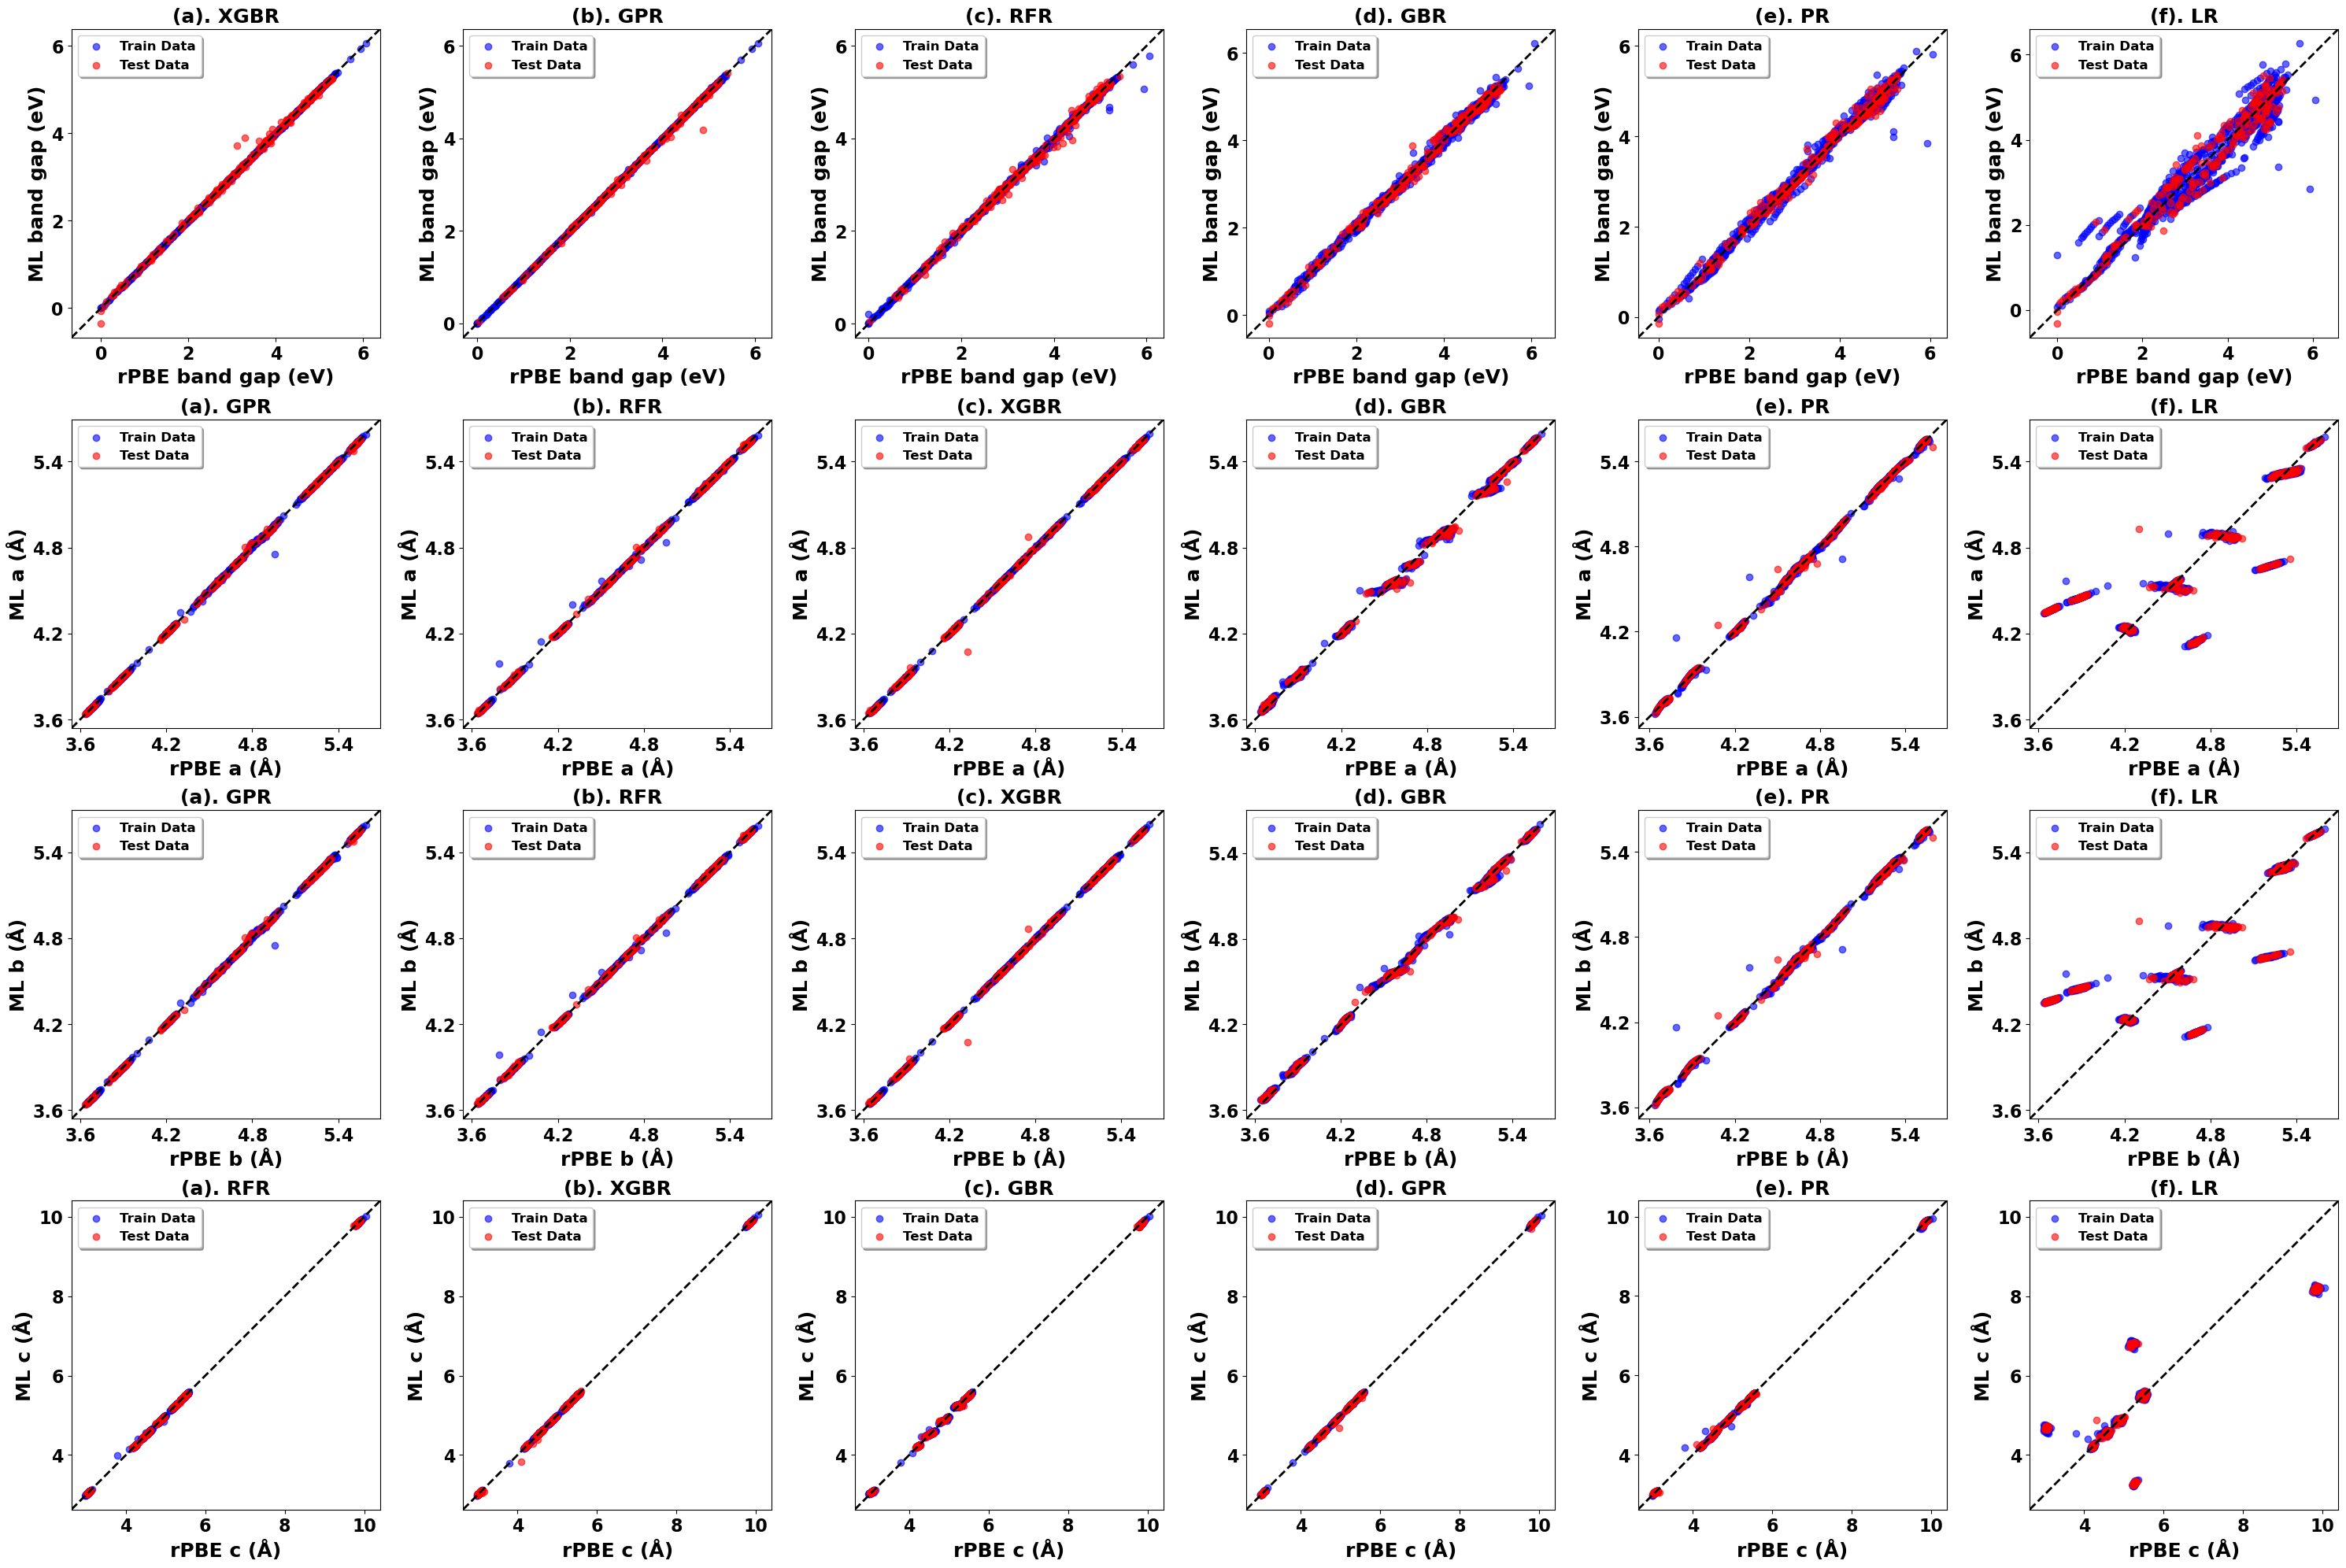

In [6]:
def cross_val_train_eval_models(models, X, y, cv=10):
    evaluation_results = {target: {} for target in y.columns}
    best_fold_data = {target: {} for target in y.columns}
    
    if cv == 'loo':
        cv = LeaveOneOut()
    else:
        cv = KFold(n_splits=cv, shuffle=True, random_state=100)

    for target in y.columns:
        for name, model in models.items():
            fold_metrics = {'train': [], 'test': []}
            best_fold_mse = float('inf')
            best_fold_index = -1

            for i, (train_index, test_index) in enumerate(cv.split(X)):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y[target].iloc[train_index], y[target].iloc[test_index]

                assert set(X_train.index).isdisjoint(set(X_test.index)), "Data leakage detected"

                model.fit(X_train, y_train)
                y_train_pred = model.predict(X_train)
                y_test_pred = model.predict(X_test)

                train_metrics = calculate_metrics(y_train, y_train_pred)
                test_metrics = calculate_metrics(y_test, y_test_pred)
                
                fold_metrics['train'].append(train_metrics)
                fold_metrics['test'].append(test_metrics)

                if test_metrics['mse'] < best_fold_mse:
                    best_fold_mse = test_metrics['mse']
                    best_fold_index = i
                    best_fold_data[target][name] = {
                        'train_index': train_index, 'test_index': test_index,
                        'model': model,
                        'best_fold_train_metrics': train_metrics,
                        'best_fold_test_metrics': test_metrics,
                        'best_train_actuals': y_train,
                        'best_train_predictions': y_train_pred,
                        'best_test_actuals': y_test,
                        'best_test_predictions': y_test_pred
                    }

            avg_metrics = {
                'train': {k: np.mean([fold[k] for fold in fold_metrics['train']]) for k in fold_metrics['train'][0]},
                'test': {k: np.mean([fold[k] for fold in fold_metrics['test']]) for k in fold_metrics['test'][0]}
            }
            evaluation_results[target][name] = {
                'avg_train_metrics': avg_metrics['train'],
                'avg_test_metrics': avg_metrics['test'],
                'best_fold': best_fold_index
            }

    return evaluation_results, best_fold_data

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred) if len(y_true) > 1 else np.nan
    return {
        'mse': mse,
        'rmse': np.sqrt(mse),
        'mae': mae,
        'r2': r2
    }

def plot_best_fold_all(sorted_evaluation_results, X, y, best_fold_data):
    num_targets = len(y.columns)
    num_models = len(sorted_evaluation_results[y.columns[0]])
    fig, axes = plt.subplots(nrows=num_targets, ncols=num_models, figsize=(num_models * 5, num_targets * 5))
    
    if num_targets == 1:
        axes = [axes]
    if num_models == 1:
        axes = [[ax] for ax in axes]

    model_abbreviations = {
        'Linear': 'LR',
        'Random Forest': 'RFR',
        'Gradient Boosting': 'GBR',
        'XGBoost': 'XGBR',
        'Gaussian Process': 'GPR',
        'Polynomial': 'PR',
        'Ridge': 'RR',
        'Decision Tree': 'DTR'
    }
    
    target_labels = {
        'Calculated_Band_Gap/eV': ('rPBE band gap (eV)', 'ML band gap (eV)'),
        #'Calculated_a/angstrom': ('rPBE a ≡ b (Å)', 'ML a ≡ b (Å)'),
        'Calculated_a/angstrom': ('rPBE a (Å)', 'ML a (Å)'),
        'Calculated_b/angstrom': ('rPBE b (Å)', 'ML b (Å)'),
        'Calculated_c/angstrom': ('rPBE c (Å)', 'ML c (Å)')
    }

    for target_index, target in enumerate(y.columns):
        for model_index, (name, _) in enumerate(sorted_evaluation_results[target]):
            ax = axes[target_index][model_index]
            data = best_fold_data[target][name]
            
            plot_scatter(ax, data['best_train_actuals'], data['best_train_predictions'], 
                         data['best_test_actuals'], data['best_test_predictions'])
            
            model_abbr = model_abbreviations.get(name, name)
            alphabet_label = chr(97 + model_index)  # 97 is the ASCII code for 'a'
            ax.set_title(f'({alphabet_label}). {model_abbr}', fontsize=18, weight='bold')
            #ax.set_title(f'{model_abbr}', fontsize=18, weight='bold')
            
            x_label, y_label = target_labels.get(target, ('rPBE', 'ML Predicted'))
            ax.set_xlabel(x_label, fontsize=18, weight='bold')
            ax.set_ylabel(y_label, fontsize=18, weight='bold')
            
            ax.set_aspect('equal', adjustable='box')
            ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
            ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
            ax.tick_params(axis='both', which='major', labelsize=16)
            
            for label in ax.get_xticklabels() + ax.get_yticklabels():
                label.set_fontweight('bold')
            
            ax.legend(prop={'size': 12, 'weight': 'bold'}, title_fontsize='12', shadow=True, frameon=True)
    
    plt.tight_layout()
    plt.show()

def plot_scatter(ax, y_train, y_train_pred, y_test, y_test_pred):
    ax.scatter(y_train, y_train_pred, color='blue', label='Train Data', alpha=0.6)
    ax.scatter(y_test, y_test_pred, color='red', label='Test Data', alpha=0.6)
    
    all_vals = np.concatenate([y_train, y_train_pred, y_test, y_test_pred])
    min_val, max_val = np.min(all_vals), np.max(all_vals)
    buffer = (max_val - min_val) * 0.05
    
    ax.plot([min_val - buffer, max_val + buffer], [min_val - buffer, max_val + buffer], 'k--', lw=2)
    ax.set_xlim([min_val - buffer, max_val + buffer])
    ax.set_ylim([min_val - buffer, max_val + buffer])

# Load data: Ensure that the Excel sheet is in the same location as this notebook for the predefined entries below to work correctly.

# All Oxides including Extrapolation Data
data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='All_Systems + Extra')

# Individual Primary Oxides without Extrapolation Data
#data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Rutile TiO2 Orig')
#data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Anatase TiO2 Orig')
#data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Cubic ZnO Orig')
#data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Cubic ZnO2 Orig')
#data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Cubic ZrO2 Orig')
#data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Cubic CeO2 Orig')

# All Primary Oxides without Extrapolation Data
#data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='All_Primary_System')


# All available features: Technically, you do not need the features of the oxygen atom because they are the same across all metal oxides and provide no variance, making them not useful for training the model.
features = ["Up_Value/eV", "Ud_Value/eV", "alpha_oxide/degree", "beta_oxide/degree", "gamma_oxide/degree", "Number of X atoms", "Number of O atoms", "Lattice_constant_a_of_X_pm", "Lattice_constant_b_of_X_pm", "Lattice_constant_c_of_X_pm", "Atomic_radius/pm_of_X",  "Van_der_Waals_radius/pm_of_X", "Atomic_No_of_X", "Atomic_Mass/amu_of_X", "Period_of_X", "First_ionization_energy/KJ/mol_of_X", "Density/Kg/m^3_of_X", "Electron_Affinity/ev_of_X", "Work_Function/ev_of_X", "Pauling_Electronegativity/units_of_X", "d-shell_of_X", "Lattice_angle_alpha_of_X_degree", "Lattice_angle_beta_of_X_degree", "Lattice_angle_gamma_of_X_degree", "Lattice_constant_a_of_O_pm", "Lattice_constant_b_of_O_pm", "Lattice_constant_c_of_O_pm", "Atomic_radius/pm_of_O", "Van_der_Waals_radius/pm_of_O", "Atomic_No_of_O", "Atomic_Mass/amu_of_O", "Period_of_O", "First_ionization_energy/KJ/mol_of_O", "Density/Kg/m^3_of_O", "Electron_Affinity/ev_of_O", "Pauling_Electronegativity/units_of_O", "Lattice_angle_alpha_of_O_degree", "Lattice_angle_beta_of_O_degree", "Lattice_angle_gamma_of_O_degree"]

# Ud/f and Up as features: When training model per metal oxide. 
#features = ["Ud_Value/eV", "Up_Value/eV"]

X = data[features]
y = data[['Calculated_Band_Gap/eV', 'Calculated_a/angstrom', 'Calculated_b/angstrom', 'Calculated_c/angstrom']]

# Define models
models = {
    'Linear': Pipeline([('regressor', LinearRegression())]),
    'Polynomial': Pipeline([('poly', PolynomialFeatures(2)), ('regressor', LinearRegression())]),
    'Random Forest': Pipeline([('scaler', StandardScaler()), ('regressor', RandomForestRegressor(random_state=100))]),
    'Gradient Boosting': Pipeline([('scaler', StandardScaler()), ('regressor', GradientBoostingRegressor(random_state=100))]),
    'XGBoost': Pipeline([('scaler', StandardScaler()), ('regressor', XGBRegressor(random_state=100))]),
    'Gaussian Process': Pipeline([('regressor', GaussianProcessRegressor(kernel=RBF(), alpha=0.0001, random_state=100))]), 
    #'Ridge': Pipeline([('regressor', Ridge())]),
    #'Decision Tree': Pipeline([('scaler', StandardScaler()), ('regressor', DecisionTreeRegressor(random_state=100))])
}

evaluation_results, best_fold_data = cross_val_train_eval_models(models, X, y, cv=5)

sorted_evaluation_results = {target: sorted(evaluation_results[target].items(), 
                                            key=lambda x: x[1]['avg_test_metrics']['mse']) 
                             for target in y.columns}

for target in y.columns:
    print(f"\nModel Performance Metrics for {target} (sorted by Test MSE):")
    for name, metrics in sorted_evaluation_results[target]:
        avg_train = metrics['avg_train_metrics']
        avg_test = metrics['avg_test_metrics']
        best_train = best_fold_data[target][name]['best_fold_train_metrics']
        best_test = best_fold_data[target][name]['best_fold_test_metrics']

        print(f"{name}:")
        print(f"  Average Train Metrics - MSE = {avg_train['mse']:.2f}, RMSE = {avg_train['rmse']:.2f}, "
              f"MAE = {avg_train['mae']:.2f}, R2 = {avg_train['r2']:.2f}")
        print(f"  Average Test Metrics - MSE = {avg_test['mse']:.2f}, RMSE = {avg_test['rmse']:.2f}, "
              f"MAE = {avg_test['mae']:.2f}, R2 = {avg_test['r2']:.2f}")
        print(f"  Best Fold Train Metrics - MSE = {best_train['mse']:.2f}, RMSE = {best_train['rmse']:.2f}, "
              f"MAE = {best_train['mae']:.2f}, R2 = {best_train['r2']:.2f}")
        print(f"  Best Fold Test Metrics - MSE = {best_test['mse']:.2f}, RMSE = {best_test['rmse']:.2f}, "
              f"MAE = {best_test['mae']:.2f}, R2 = {best_test['r2']:.2f}\n")

plot_best_fold_all(sorted_evaluation_results, X, y, best_fold_data)


Model Performance Metrics for Calculated_Band_Gap/eV (sorted by Test MSE):
Gaussian Process:
  Train Metrics - MSE = 0.00, RMSE = 0.01, MAE = 0.00, R2 = 1.00
  Test Metrics - MSE = 0.00, RMSE = 0.01, MAE = 0.00, R2 = 1.00

XGBoost:
  Train Metrics - MSE = 0.00, RMSE = 0.01, MAE = 0.00, R2 = 1.00
  Test Metrics - MSE = 0.00, RMSE = 0.01, MAE = 0.00, R2 = 1.00

Random Forest:
  Train Metrics - MSE = 0.00, RMSE = 0.07, MAE = 0.02, R2 = 1.00
  Test Metrics - MSE = 0.00, RMSE = 0.07, MAE = 0.02, R2 = 1.00

Gradient Boosting:
  Train Metrics - MSE = 0.01, RMSE = 0.07, MAE = 0.05, R2 = 0.99
  Test Metrics - MSE = 0.01, RMSE = 0.07, MAE = 0.05, R2 = 0.99

Polynomial:
  Train Metrics - MSE = 0.02, RMSE = 0.13, MAE = 0.06, R2 = 0.98
  Test Metrics - MSE = 0.02, RMSE = 0.13, MAE = 0.06, R2 = 0.98

Linear:
  Train Metrics - MSE = 0.06, RMSE = 0.24, MAE = 0.13, R2 = 0.94
  Test Metrics - MSE = 0.06, RMSE = 0.24, MAE = 0.13, R2 = 0.94


Model Performance Metrics for Calculated_a/angstrom (sorted by

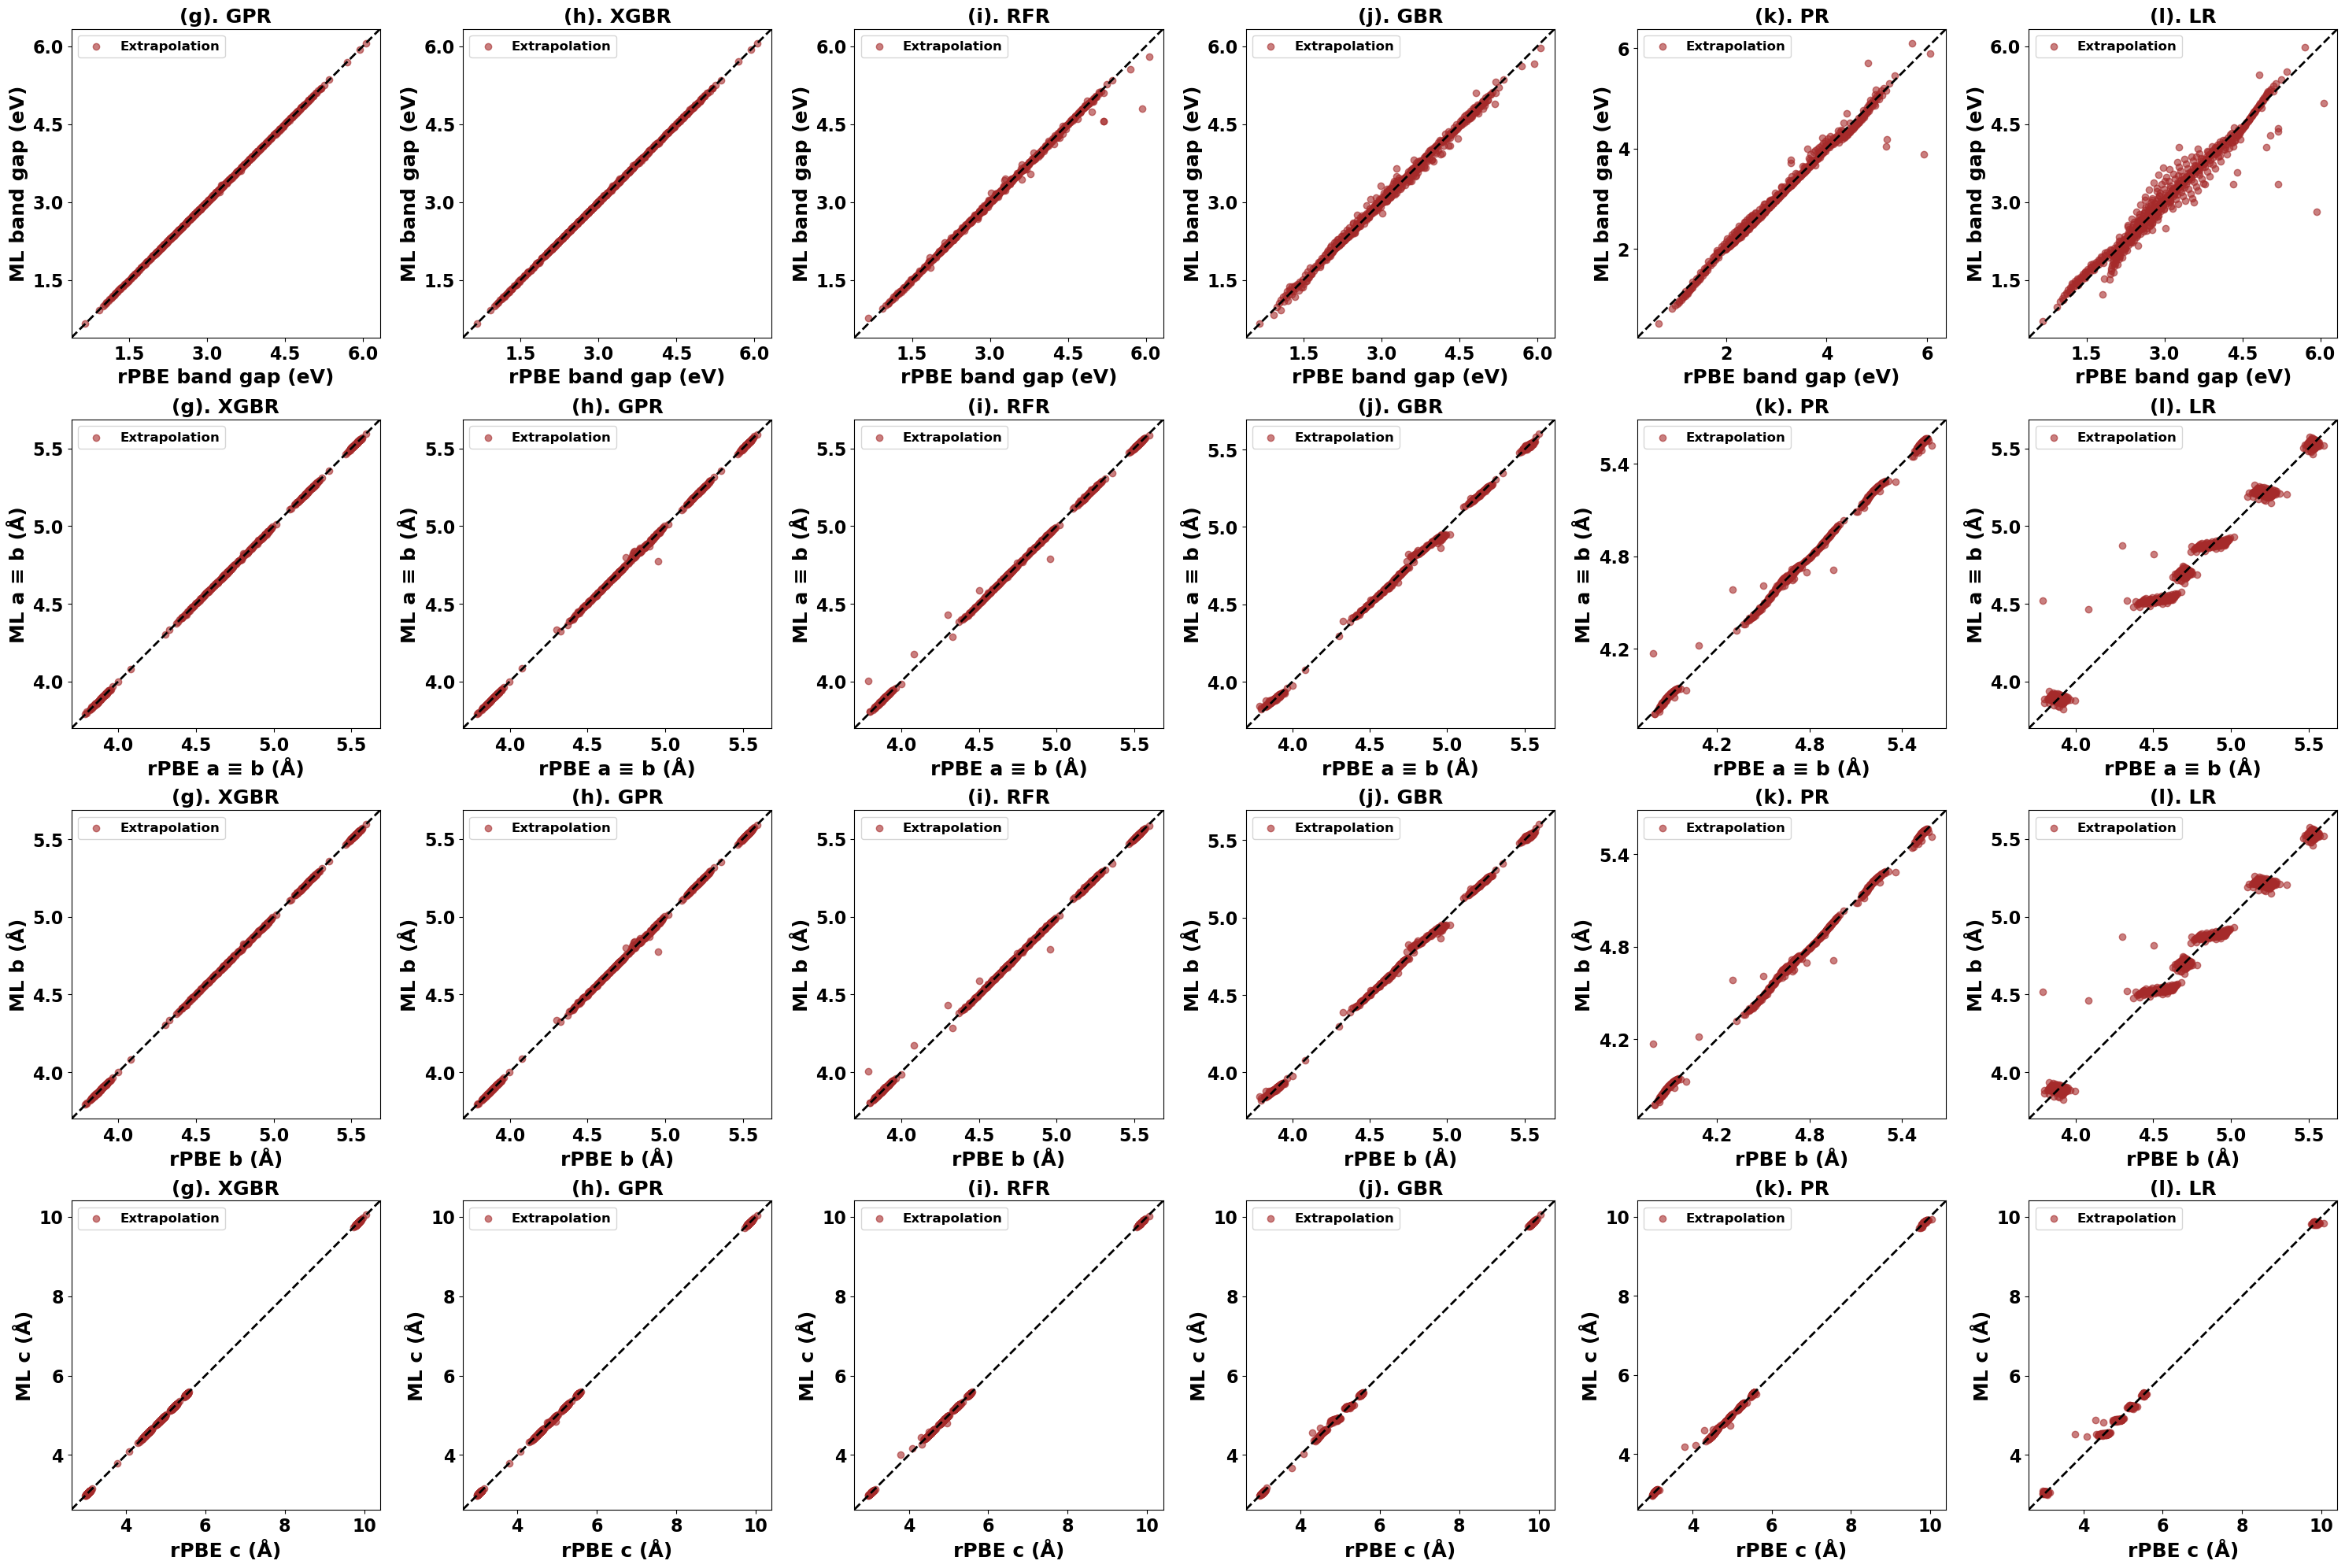


Feature importance for Calculated_Band_Gap/eV:


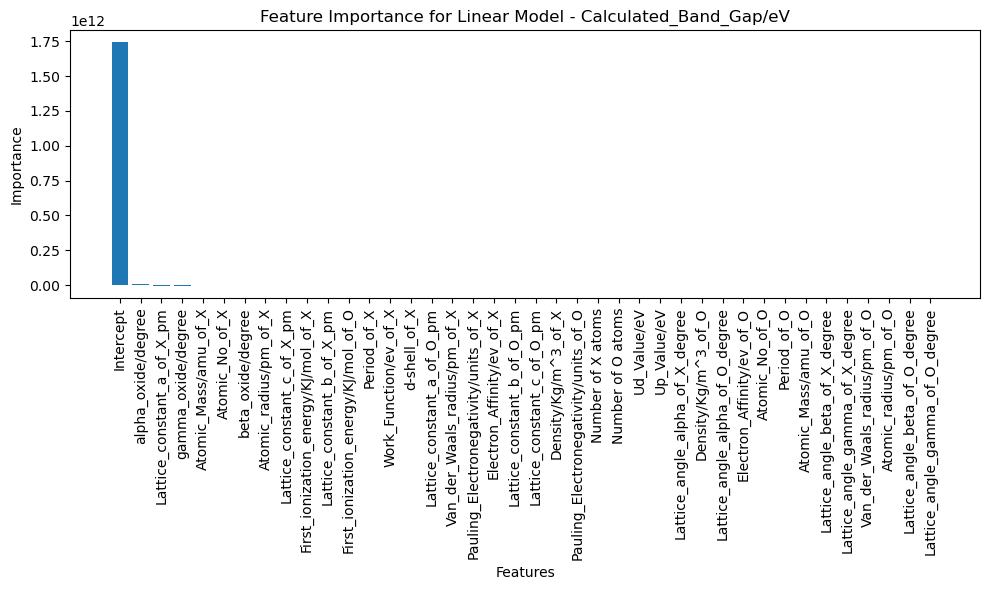

  Linear model:
    Intercept: 1741601580069.7161
    alpha_oxide/degree: 5660155064.7668
    Lattice_constant_a_of_X_pm: -4719048778.0330
    gamma_oxide/degree: -4411874225.8630
    Atomic_Mass/amu_of_X: 2672973426.2095
    Atomic_No_of_X: 1663827302.8866
    beta_oxide/degree: 1013743760.2250
    Atomic_radius/pm_of_X: 1010584175.7001
    Lattice_constant_c_of_X_pm: -889253331.1424
    First_ionization_energy/KJ/mol_of_X: -783371279.9581
    Lattice_constant_b_of_X_pm: -463036740.1359
    First_ionization_energy/KJ/mol_of_O: 125100992.4097
    Period_of_X: 82570055.2444
    Work_Function/ev_of_X: -58039551.8073
    d-shell_of_X: 40072301.0244
    Lattice_constant_a_of_O_pm: 31275248.1024
    Van_der_Waals_radius/pm_of_X: 30913560.2163
    Pauling_Electronegativity/units_of_X: -23635400.7563
    Electron_Affinity/ev_of_X: 19823171.8064
    Lattice_constant_b_of_O_pm: 15637624.0512
    Lattice_constant_c_of_O_pm: -15637624.0512
    Density/Kg/m^3_of_X: 5372467.7639
    Pauling_Electro

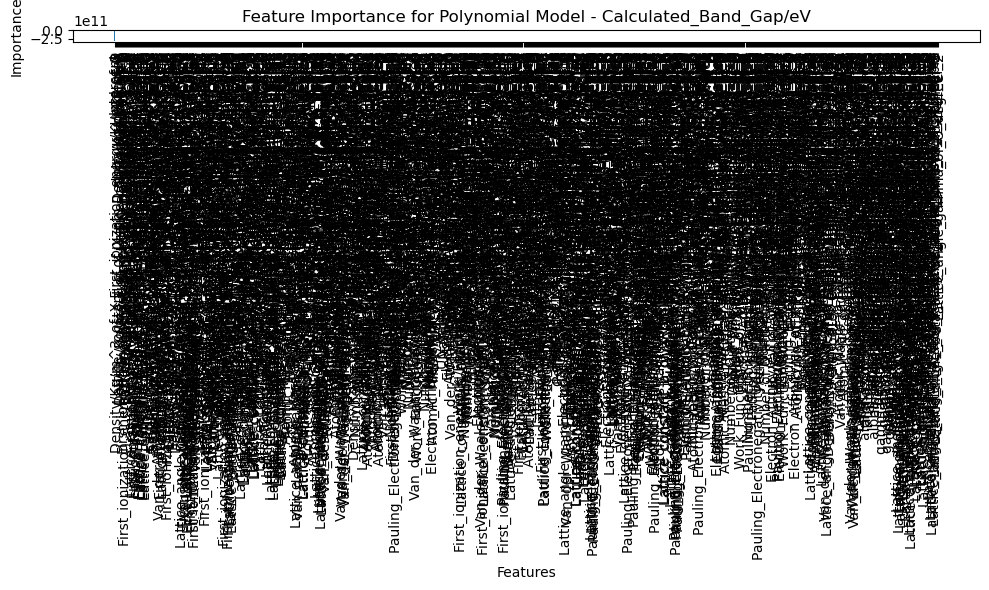

  Polynomial model:
    Intercept: -332842379532.3926
    1: -455267.8458
    Density/Kg/m^3_of_X First_ionization_energy/KJ/mol_of_O: 62682.2997
    alpha_oxide/degree: 62584.2915
    Lattice_constant_c_of_X_pm Density/Kg/m^3_of_X: 37329.8392
    Ud_Value/eV: 30978.2311
    Density/Kg/m^3_of_X Lattice_constant_a_of_O_pm: 23831.0029
    Up_Value/eV: -23479.0336
    First_ionization_energy/KJ/mol_of_O^2: 17792.7832
    First_ionization_energy/KJ/mol_of_O Density/Kg/m^3_of_O: -16735.7862
    First_ionization_energy/KJ/mol_of_X First_ionization_energy/KJ/mol_of_O: 16474.8296
    Lattice_constant_b_of_X_pm Density/Kg/m^3_of_X: -15928.4545
    Lattice_constant_a_of_X_pm Density/Kg/m^3_of_X: -15928.4545
    Density/Kg/m^3_of_X Density/Kg/m^3_of_O: 14589.2171
    Atomic_Mass/amu_of_X Density/Kg/m^3_of_X: -11727.6445
    Density/Kg/m^3_of_X^2: -10666.6412
    Density/Kg/m^3_of_X Lattice_constant_c_of_O_pm: -10633.4225
    Lattice_constant_c_of_X_pm First_ionization_energy/KJ/mol_of_X: 9601.799

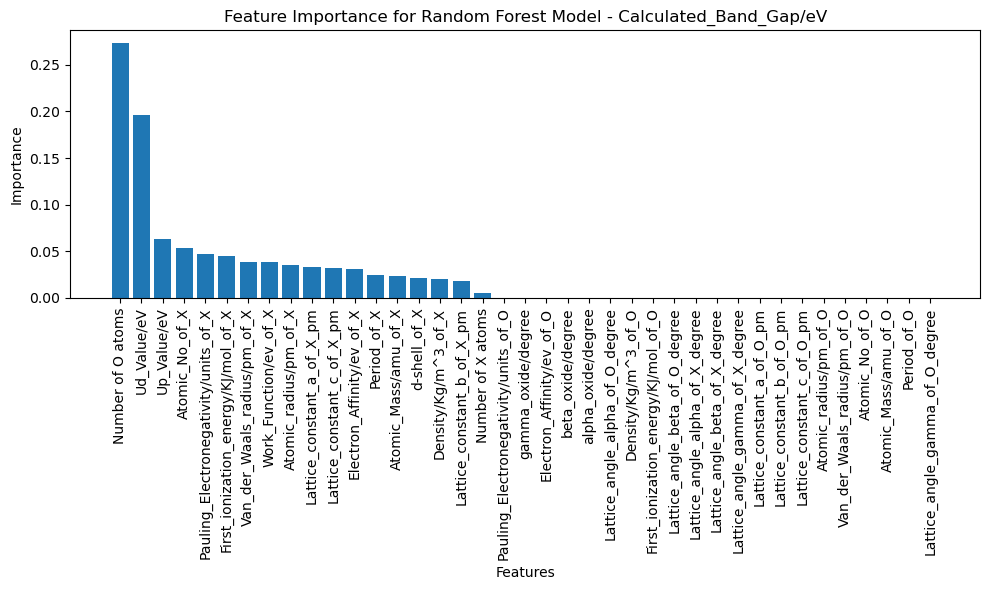

  Random Forest model:
    Number of O atoms: 0.2733
    Ud_Value/eV: 0.1963
    Up_Value/eV: 0.0627
    Atomic_No_of_X: 0.0538
    Pauling_Electronegativity/units_of_X: 0.0473
    First_ionization_energy/KJ/mol_of_X: 0.0454
    Van_der_Waals_radius/pm_of_X: 0.0385
    Work_Function/ev_of_X: 0.0380
    Atomic_radius/pm_of_X: 0.0351
    Lattice_constant_a_of_X_pm: 0.0327
    Lattice_constant_c_of_X_pm: 0.0324
    Electron_Affinity/ev_of_X: 0.0310
    Period_of_X: 0.0248
    Atomic_Mass/amu_of_X: 0.0238
    d-shell_of_X: 0.0213
    Density/Kg/m^3_of_X: 0.0206
    Lattice_constant_b_of_X_pm: 0.0177
    Number of X atoms: 0.0053
    Pauling_Electronegativity/units_of_O: 0.0000
    gamma_oxide/degree: 0.0000
    Electron_Affinity/ev_of_O: 0.0000
    beta_oxide/degree: 0.0000
    alpha_oxide/degree: 0.0000
    Lattice_angle_alpha_of_O_degree: 0.0000
    Density/Kg/m^3_of_O: 0.0000
    First_ionization_energy/KJ/mol_of_O: 0.0000
    Lattice_angle_beta_of_O_degree: 0.0000
    Lattice_angle_alp

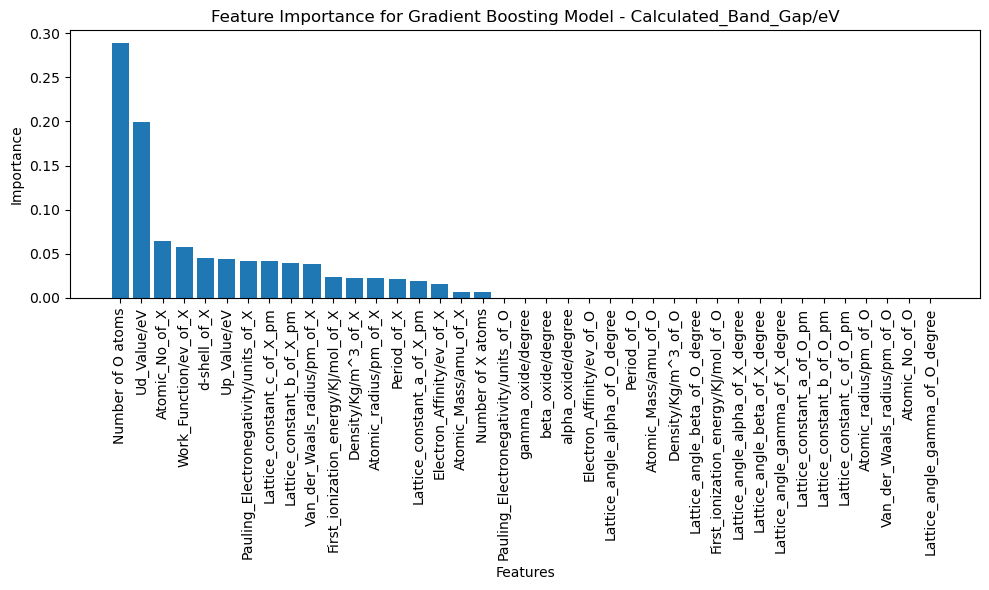

  Gradient Boosting model:
    Number of O atoms: 0.2889
    Ud_Value/eV: 0.1999
    Atomic_No_of_X: 0.0648
    Work_Function/ev_of_X: 0.0571
    d-shell_of_X: 0.0449
    Up_Value/eV: 0.0444
    Pauling_Electronegativity/units_of_X: 0.0422
    Lattice_constant_c_of_X_pm: 0.0417
    Lattice_constant_b_of_X_pm: 0.0391
    Van_der_Waals_radius/pm_of_X: 0.0383
    First_ionization_energy/KJ/mol_of_X: 0.0235
    Density/Kg/m^3_of_X: 0.0227
    Atomic_radius/pm_of_X: 0.0225
    Period_of_X: 0.0219
    Lattice_constant_a_of_X_pm: 0.0189
    Electron_Affinity/ev_of_X: 0.0159
    Atomic_Mass/amu_of_X: 0.0070
    Number of X atoms: 0.0063
    Pauling_Electronegativity/units_of_O: 0.0000
    gamma_oxide/degree: 0.0000
    beta_oxide/degree: 0.0000
    alpha_oxide/degree: 0.0000
    Electron_Affinity/ev_of_O: 0.0000
    Lattice_angle_alpha_of_O_degree: 0.0000
    Period_of_O: 0.0000
    Atomic_Mass/amu_of_O: 0.0000
    Density/Kg/m^3_of_O: 0.0000
    Lattice_angle_beta_of_O_degree: 0.0000
    Firs

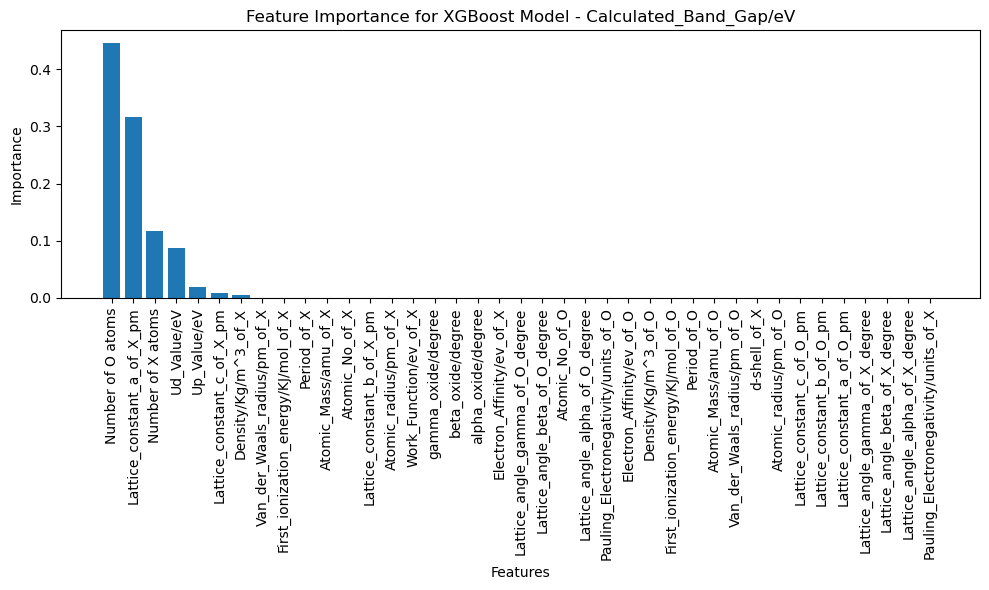

  XGBoost model:
    Number of O atoms: 0.4459
    Lattice_constant_a_of_X_pm: 0.3164
    Number of X atoms: 0.1174
    Ud_Value/eV: 0.0878
    Up_Value/eV: 0.0188
    Lattice_constant_c_of_X_pm: 0.0086
    Density/Kg/m^3_of_X: 0.0051
    Van_der_Waals_radius/pm_of_X: 0.0000
    First_ionization_energy/KJ/mol_of_X: 0.0000
    Period_of_X: 0.0000
    Atomic_Mass/amu_of_X: 0.0000
    Atomic_No_of_X: 0.0000
    Lattice_constant_b_of_X_pm: 0.0000
    Atomic_radius/pm_of_X: 0.0000
    Work_Function/ev_of_X: 0.0000
    gamma_oxide/degree: 0.0000
    beta_oxide/degree: 0.0000
    alpha_oxide/degree: 0.0000
    Electron_Affinity/ev_of_X: 0.0000
    Lattice_angle_gamma_of_O_degree: 0.0000
    Lattice_angle_beta_of_O_degree: 0.0000
    Atomic_No_of_O: 0.0000
    Lattice_angle_alpha_of_O_degree: 0.0000
    Pauling_Electronegativity/units_of_O: 0.0000
    Electron_Affinity/ev_of_O: 0.0000
    Density/Kg/m^3_of_O: 0.0000
    First_ionization_energy/KJ/mol_of_O: 0.0000
    Period_of_O: 0.0000
    At

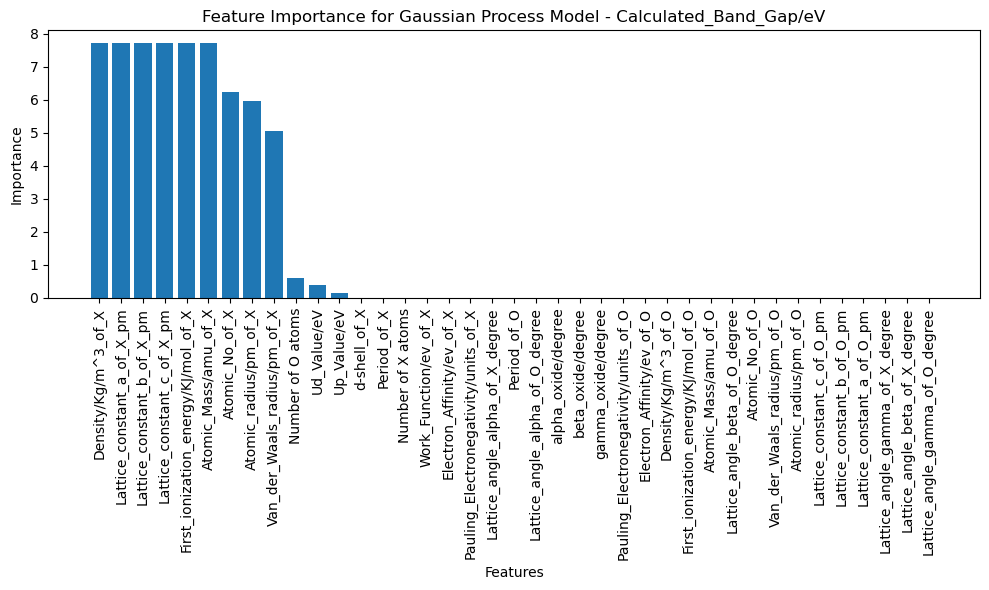

  Gaussian Process model:
    Density/Kg/m^3_of_X: 7.7235
    Lattice_constant_a_of_X_pm: 7.7235
    Lattice_constant_b_of_X_pm: 7.7235
    Lattice_constant_c_of_X_pm: 7.7219
    First_ionization_energy/KJ/mol_of_X: 7.7192
    Atomic_Mass/amu_of_X: 7.7117
    Atomic_No_of_X: 6.2513
    Atomic_radius/pm_of_X: 5.9606
    Van_der_Waals_radius/pm_of_X: 5.0609
    Number of O atoms: 0.5886
    Ud_Value/eV: 0.3796
    Up_Value/eV: 0.1399
    d-shell_of_X: 0.0102
    Period_of_X: 0.0102
    Number of X atoms: 0.0084
    Work_Function/ev_of_X: 0.0020
    Electron_Affinity/ev_of_X: 0.0001
    Pauling_Electronegativity/units_of_X: 0.0000
    Lattice_angle_alpha_of_X_degree: 0.0000
    Period_of_O: 0.0000
    Lattice_angle_alpha_of_O_degree: 0.0000
    alpha_oxide/degree: 0.0000
    beta_oxide/degree: 0.0000
    gamma_oxide/degree: 0.0000
    Pauling_Electronegativity/units_of_O: 0.0000
    Electron_Affinity/ev_of_O: 0.0000
    Density/Kg/m^3_of_O: 0.0000
    First_ionization_energy/KJ/mol_of_O: 

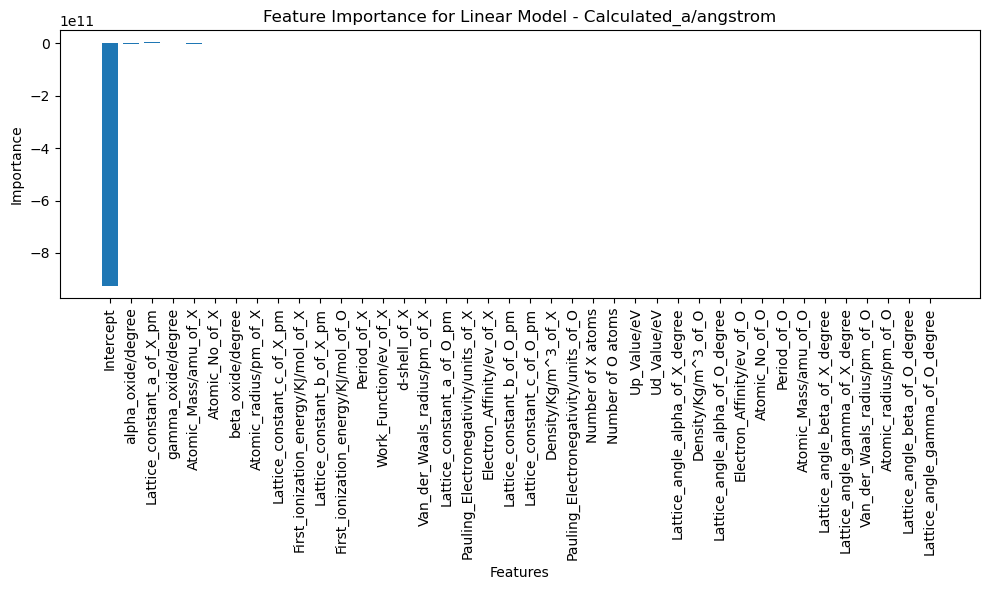

  Linear model:
    Intercept: -924619429897.9470
    alpha_oxide/degree: -2957463933.0182
    Lattice_constant_a_of_X_pm: 2466028101.0299
    gamma_oxide/degree: 2305588021.4648
    Atomic_Mass/amu_of_X: -1396893448.4687
    Atomic_No_of_X: -869561312.7161
    beta_oxide/degree: -530254389.0629
    Atomic_radius/pm_of_X: -527889347.0198
    Lattice_constant_c_of_X_pm: 464896292.5465
    First_ionization_energy/KJ/mol_of_X: 409357138.7726
    Lattice_constant_b_of_X_pm: 241923943.2407
    First_ionization_energy/KJ/mol_of_O: -55194641.3079
    Period_of_X: -43149356.7915
    Work_Function/ev_of_X: 30342409.8968
    d-shell_of_X: -20937074.1941
    Van_der_Waals_radius/pm_of_X: -16608322.8725
    Lattice_constant_a_of_O_pm: -13798660.3270
    Pauling_Electronegativity/units_of_X: 12355288.8335
    Electron_Affinity/ev_of_X: -10356349.9978
    Lattice_constant_b_of_O_pm: -6899330.1635
    Lattice_constant_c_of_O_pm: 6899330.1635
    Density/Kg/m^3_of_X: -2809145.4874
    Pauling_Electron

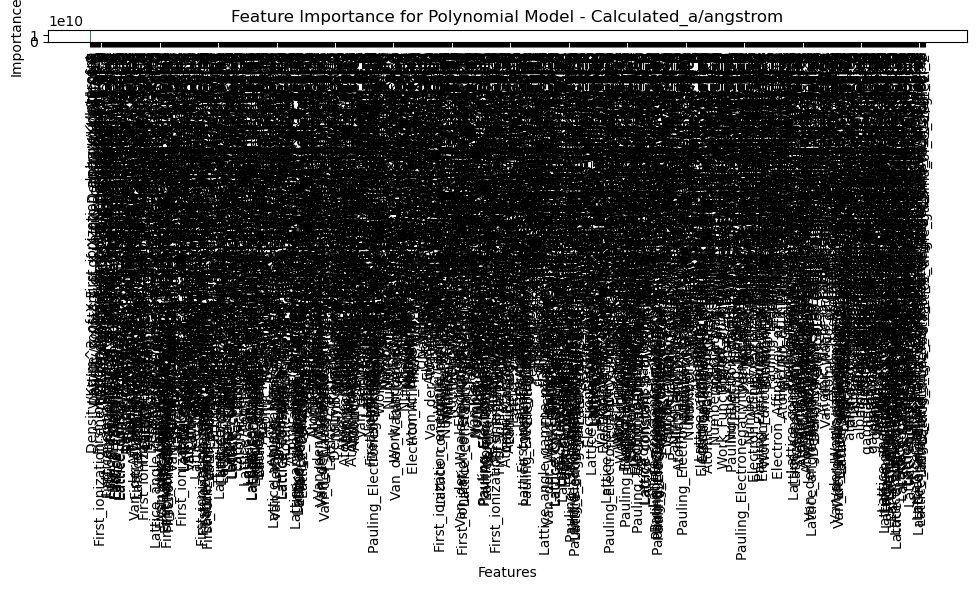

  Polynomial model:
    Intercept: 16343946908.5815
    1: 22417.8806
    alpha_oxide/degree: -3082.1217
    Density/Kg/m^3_of_X First_ionization_energy/KJ/mol_of_O: -3069.6102
    Lattice_constant_c_of_X_pm Density/Kg/m^3_of_X: -1842.4453
    Ud_Value/eV: -1525.3861
    Density/Kg/m^3_of_X Lattice_constant_a_of_O_pm: -1176.7852
    Up_Value/eV: 1156.4414
    First_ionization_energy/KJ/mol_of_O^2: -891.9095
    First_ionization_energy/KJ/mol_of_O Density/Kg/m^3_of_O: 838.9247
    First_ionization_energy/KJ/mol_of_X First_ionization_energy/KJ/mol_of_O: -816.6021
    Lattice_constant_b_of_X_pm Density/Kg/m^3_of_X: 775.9230
    Lattice_constant_a_of_X_pm Density/Kg/m^3_of_X: 775.9230
    Density/Kg/m^3_of_X Density/Kg/m^3_of_O: -721.8360
    Atomic_Mass/amu_of_X Density/Kg/m^3_of_X: 584.1291
    Density/Kg/m^3_of_X Lattice_constant_c_of_O_pm: 524.4931
    Density/Kg/m^3_of_X^2: 524.0054
    Lattice_constant_c_of_X_pm First_ionization_energy/KJ/mol_of_X: -474.5841
    First_ionization_ener

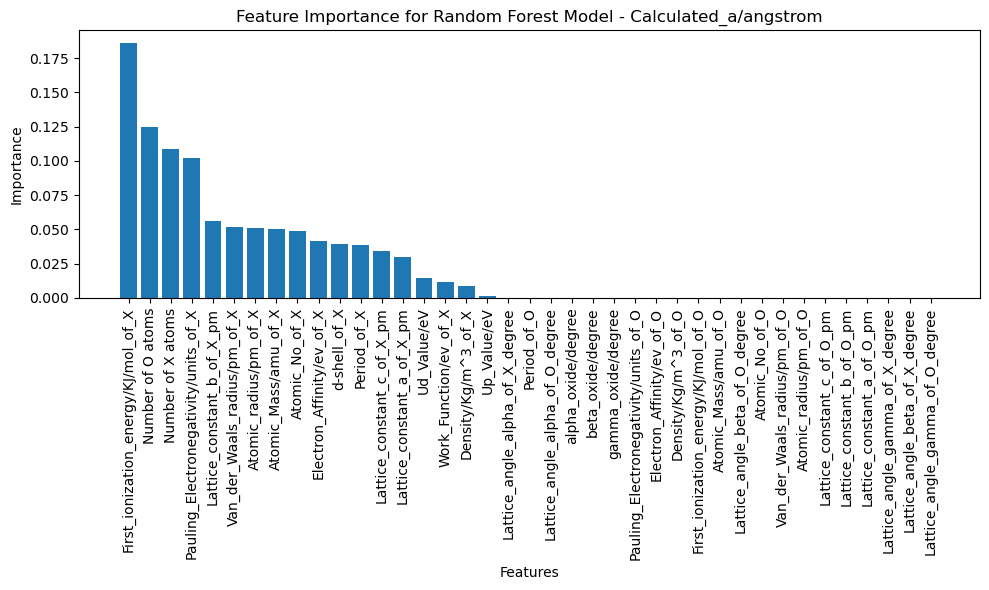

  Random Forest model:
    First_ionization_energy/KJ/mol_of_X: 0.1861
    Number of O atoms: 0.1248
    Number of X atoms: 0.1091
    Pauling_Electronegativity/units_of_X: 0.1022
    Lattice_constant_b_of_X_pm: 0.0563
    Van_der_Waals_radius/pm_of_X: 0.0517
    Atomic_radius/pm_of_X: 0.0512
    Atomic_Mass/amu_of_X: 0.0502
    Atomic_No_of_X: 0.0489
    Electron_Affinity/ev_of_X: 0.0416
    d-shell_of_X: 0.0393
    Period_of_X: 0.0389
    Lattice_constant_c_of_X_pm: 0.0344
    Lattice_constant_a_of_X_pm: 0.0297
    Ud_Value/eV: 0.0148
    Work_Function/ev_of_X: 0.0112
    Density/Kg/m^3_of_X: 0.0083
    Up_Value/eV: 0.0013
    Lattice_angle_alpha_of_X_degree: 0.0000
    Period_of_O: 0.0000
    Lattice_angle_alpha_of_O_degree: 0.0000
    alpha_oxide/degree: 0.0000
    beta_oxide/degree: 0.0000
    gamma_oxide/degree: 0.0000
    Pauling_Electronegativity/units_of_O: 0.0000
    Electron_Affinity/ev_of_O: 0.0000
    Density/Kg/m^3_of_O: 0.0000
    First_ionization_energy/KJ/mol_of_O: 0.0

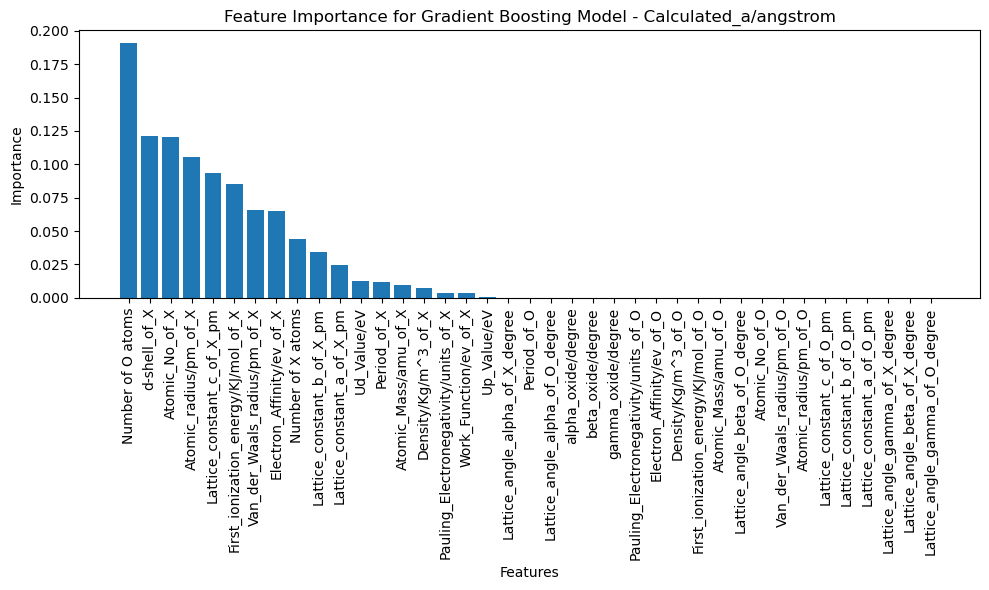

  Gradient Boosting model:
    Number of O atoms: 0.1908
    d-shell_of_X: 0.1213
    Atomic_No_of_X: 0.1204
    Atomic_radius/pm_of_X: 0.1054
    Lattice_constant_c_of_X_pm: 0.0935
    First_ionization_energy/KJ/mol_of_X: 0.0852
    Van_der_Waals_radius/pm_of_X: 0.0654
    Electron_Affinity/ev_of_X: 0.0649
    Number of X atoms: 0.0441
    Lattice_constant_b_of_X_pm: 0.0343
    Lattice_constant_a_of_X_pm: 0.0244
    Ud_Value/eV: 0.0126
    Period_of_X: 0.0121
    Atomic_Mass/amu_of_X: 0.0099
    Density/Kg/m^3_of_X: 0.0077
    Pauling_Electronegativity/units_of_X: 0.0037
    Work_Function/ev_of_X: 0.0033
    Up_Value/eV: 0.0009
    Lattice_angle_alpha_of_X_degree: 0.0000
    Period_of_O: 0.0000
    Lattice_angle_alpha_of_O_degree: 0.0000
    alpha_oxide/degree: 0.0000
    beta_oxide/degree: 0.0000
    gamma_oxide/degree: 0.0000
    Pauling_Electronegativity/units_of_O: 0.0000
    Electron_Affinity/ev_of_O: 0.0000
    Density/Kg/m^3_of_O: 0.0000
    First_ionization_energy/KJ/mol_of_O:

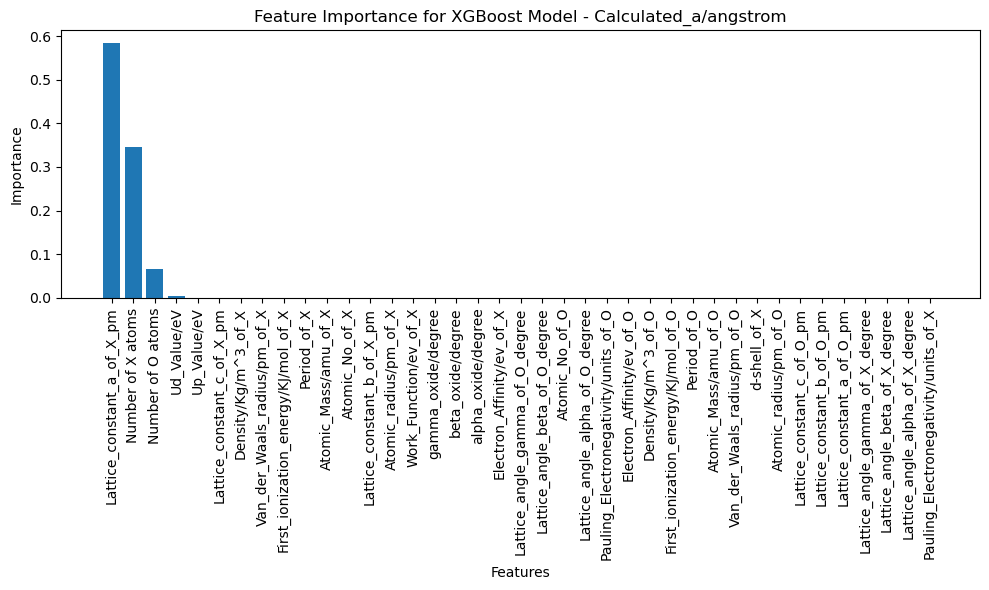

  XGBoost model:
    Lattice_constant_a_of_X_pm: 0.5841
    Number of X atoms: 0.3448
    Number of O atoms: 0.0666
    Ud_Value/eV: 0.0040
    Up_Value/eV: 0.0004
    Lattice_constant_c_of_X_pm: 0.0000
    Density/Kg/m^3_of_X: 0.0000
    Van_der_Waals_radius/pm_of_X: 0.0000
    First_ionization_energy/KJ/mol_of_X: 0.0000
    Period_of_X: 0.0000
    Atomic_Mass/amu_of_X: 0.0000
    Atomic_No_of_X: 0.0000
    Lattice_constant_b_of_X_pm: 0.0000
    Atomic_radius/pm_of_X: 0.0000
    Work_Function/ev_of_X: 0.0000
    gamma_oxide/degree: 0.0000
    beta_oxide/degree: 0.0000
    alpha_oxide/degree: 0.0000
    Electron_Affinity/ev_of_X: 0.0000
    Lattice_angle_gamma_of_O_degree: 0.0000
    Lattice_angle_beta_of_O_degree: 0.0000
    Atomic_No_of_O: 0.0000
    Lattice_angle_alpha_of_O_degree: 0.0000
    Pauling_Electronegativity/units_of_O: 0.0000
    Electron_Affinity/ev_of_O: 0.0000
    Density/Kg/m^3_of_O: 0.0000
    First_ionization_energy/KJ/mol_of_O: 0.0000
    Period_of_O: 0.0000
    At

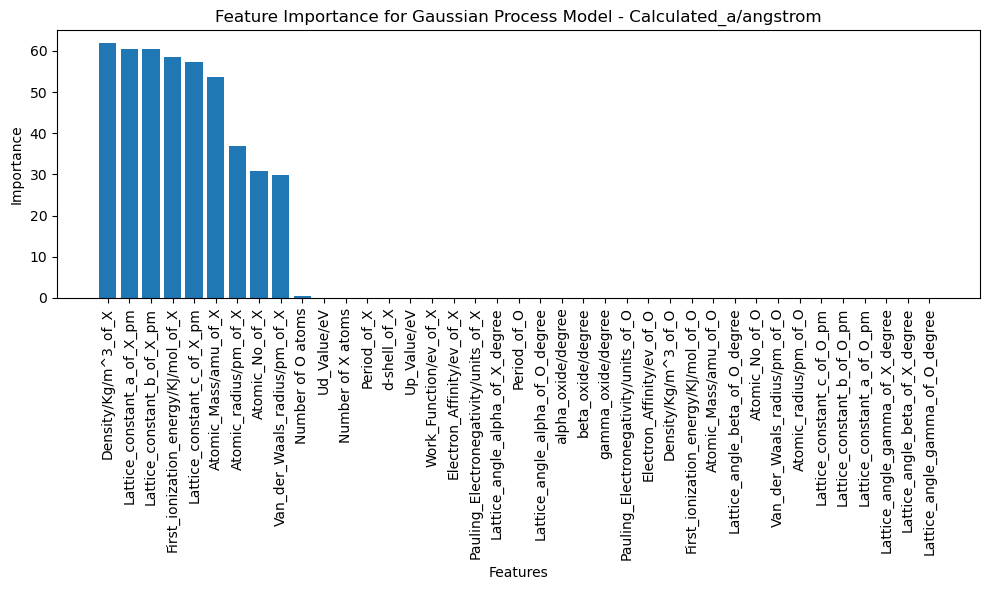

  Gaussian Process model:
    Density/Kg/m^3_of_X: 61.8934
    Lattice_constant_a_of_X_pm: 60.5285
    Lattice_constant_b_of_X_pm: 60.5285
    First_ionization_energy/KJ/mol_of_X: 58.5047
    Lattice_constant_c_of_X_pm: 57.3508
    Atomic_Mass/amu_of_X: 53.6010
    Atomic_radius/pm_of_X: 36.8220
    Atomic_No_of_X: 30.7978
    Van_der_Waals_radius/pm_of_X: 29.8539
    Number of O atoms: 0.3863
    Ud_Value/eV: 0.0269
    Number of X atoms: 0.0197
    Period_of_X: 0.0069
    d-shell_of_X: 0.0069
    Up_Value/eV: 0.0029
    Work_Function/ev_of_X: 0.0012
    Electron_Affinity/ev_of_X: 0.0000
    Pauling_Electronegativity/units_of_X: 0.0000
    Lattice_angle_alpha_of_X_degree: 0.0000
    Period_of_O: 0.0000
    Lattice_angle_alpha_of_O_degree: 0.0000
    alpha_oxide/degree: 0.0000
    beta_oxide/degree: 0.0000
    gamma_oxide/degree: 0.0000
    Pauling_Electronegativity/units_of_O: 0.0000
    Electron_Affinity/ev_of_O: 0.0000
    Density/Kg/m^3_of_O: 0.0000
    First_ionization_energy/KJ/m

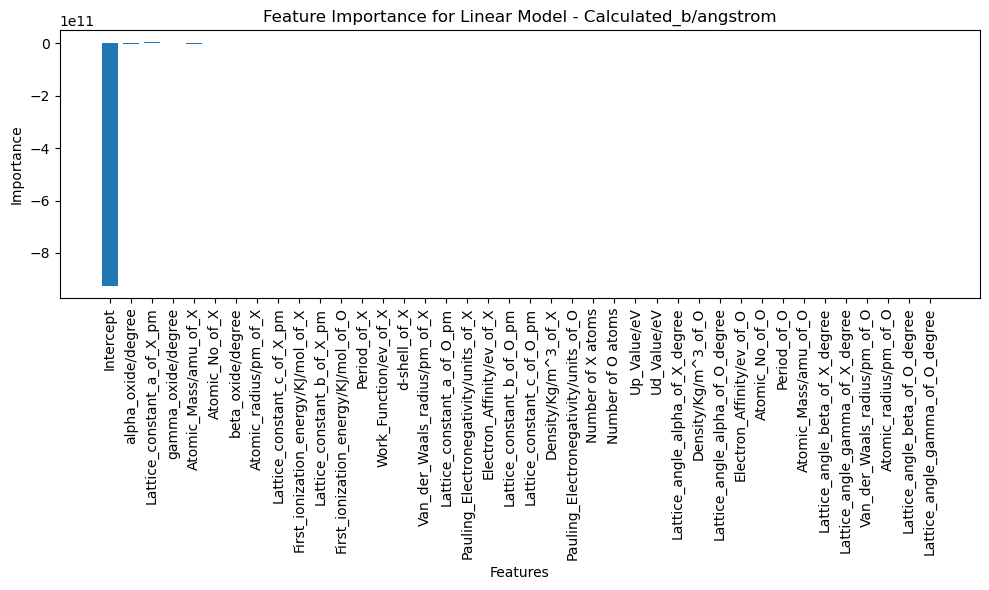

  Linear model:
    Intercept: -924619429897.9470
    alpha_oxide/degree: -2957463933.0182
    Lattice_constant_a_of_X_pm: 2466028101.0299
    gamma_oxide/degree: 2305588021.4648
    Atomic_Mass/amu_of_X: -1396893448.4687
    Atomic_No_of_X: -869561312.7161
    beta_oxide/degree: -530254389.0629
    Atomic_radius/pm_of_X: -527889347.0198
    Lattice_constant_c_of_X_pm: 464896292.5465
    First_ionization_energy/KJ/mol_of_X: 409357138.7726
    Lattice_constant_b_of_X_pm: 241923943.2407
    First_ionization_energy/KJ/mol_of_O: -55194641.3079
    Period_of_X: -43149356.7915
    Work_Function/ev_of_X: 30342409.8968
    d-shell_of_X: -20937074.1941
    Van_der_Waals_radius/pm_of_X: -16608322.8725
    Lattice_constant_a_of_O_pm: -13798660.3270
    Pauling_Electronegativity/units_of_X: 12355288.8335
    Electron_Affinity/ev_of_X: -10356349.9978
    Lattice_constant_b_of_O_pm: -6899330.1635
    Lattice_constant_c_of_O_pm: 6899330.1635
    Density/Kg/m^3_of_X: -2809145.4874
    Pauling_Electron

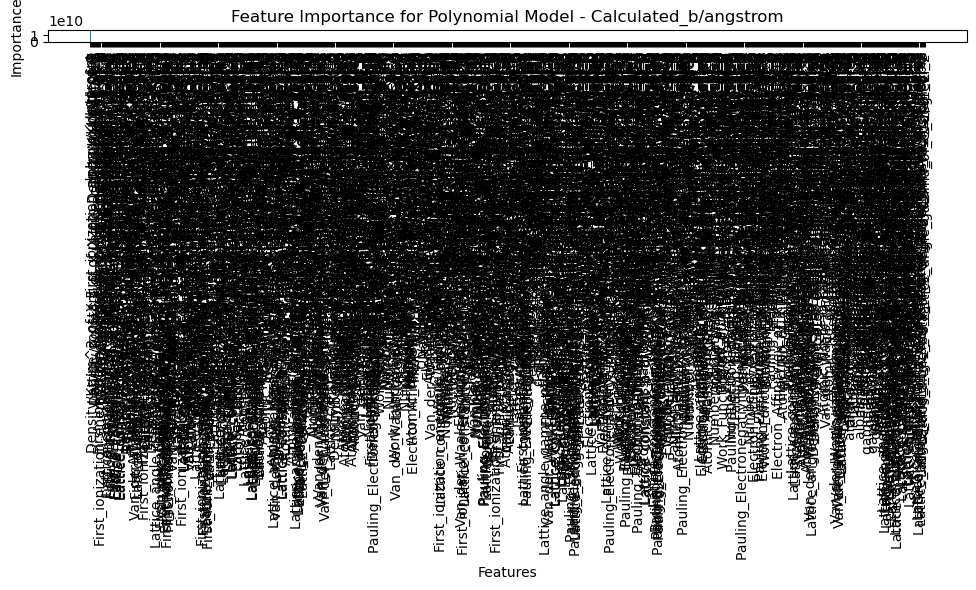

  Polynomial model:
    Intercept: 16343946908.5815
    1: 22417.8806
    alpha_oxide/degree: -3082.1217
    Density/Kg/m^3_of_X First_ionization_energy/KJ/mol_of_O: -3069.6102
    Lattice_constant_c_of_X_pm Density/Kg/m^3_of_X: -1842.4453
    Ud_Value/eV: -1525.3861
    Density/Kg/m^3_of_X Lattice_constant_a_of_O_pm: -1176.7852
    Up_Value/eV: 1156.4414
    First_ionization_energy/KJ/mol_of_O^2: -891.9095
    First_ionization_energy/KJ/mol_of_O Density/Kg/m^3_of_O: 838.9247
    First_ionization_energy/KJ/mol_of_X First_ionization_energy/KJ/mol_of_O: -816.6021
    Lattice_constant_b_of_X_pm Density/Kg/m^3_of_X: 775.9230
    Lattice_constant_a_of_X_pm Density/Kg/m^3_of_X: 775.9230
    Density/Kg/m^3_of_X Density/Kg/m^3_of_O: -721.8360
    Atomic_Mass/amu_of_X Density/Kg/m^3_of_X: 584.1291
    Density/Kg/m^3_of_X Lattice_constant_c_of_O_pm: 524.4931
    Density/Kg/m^3_of_X^2: 524.0054
    Lattice_constant_c_of_X_pm First_ionization_energy/KJ/mol_of_X: -474.5841
    First_ionization_ener

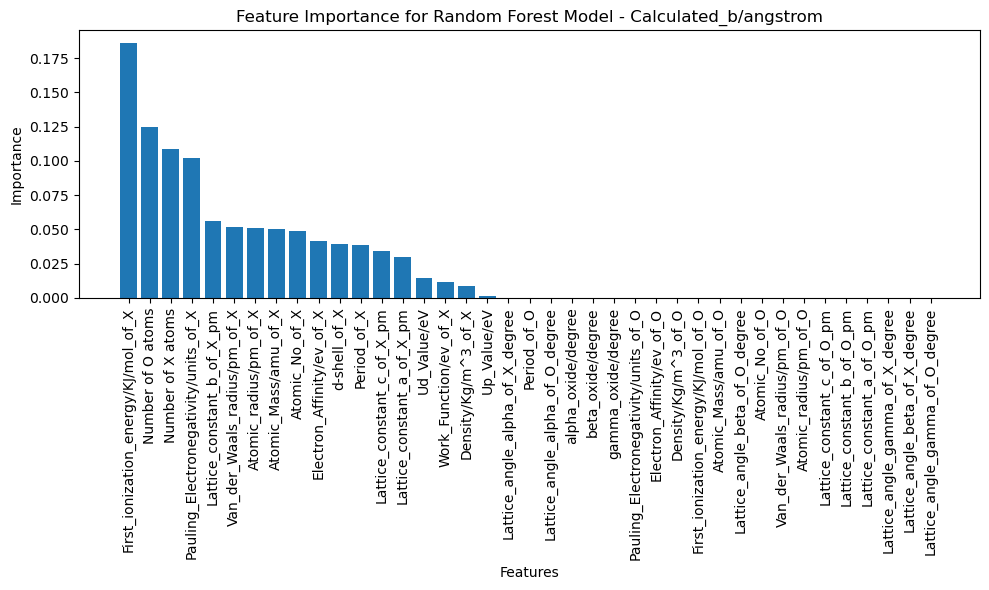

  Random Forest model:
    First_ionization_energy/KJ/mol_of_X: 0.1861
    Number of O atoms: 0.1248
    Number of X atoms: 0.1091
    Pauling_Electronegativity/units_of_X: 0.1022
    Lattice_constant_b_of_X_pm: 0.0563
    Van_der_Waals_radius/pm_of_X: 0.0517
    Atomic_radius/pm_of_X: 0.0512
    Atomic_Mass/amu_of_X: 0.0502
    Atomic_No_of_X: 0.0489
    Electron_Affinity/ev_of_X: 0.0416
    d-shell_of_X: 0.0393
    Period_of_X: 0.0389
    Lattice_constant_c_of_X_pm: 0.0344
    Lattice_constant_a_of_X_pm: 0.0297
    Ud_Value/eV: 0.0148
    Work_Function/ev_of_X: 0.0112
    Density/Kg/m^3_of_X: 0.0083
    Up_Value/eV: 0.0013
    Lattice_angle_alpha_of_X_degree: 0.0000
    Period_of_O: 0.0000
    Lattice_angle_alpha_of_O_degree: 0.0000
    alpha_oxide/degree: 0.0000
    beta_oxide/degree: 0.0000
    gamma_oxide/degree: 0.0000
    Pauling_Electronegativity/units_of_O: 0.0000
    Electron_Affinity/ev_of_O: 0.0000
    Density/Kg/m^3_of_O: 0.0000
    First_ionization_energy/KJ/mol_of_O: 0.0

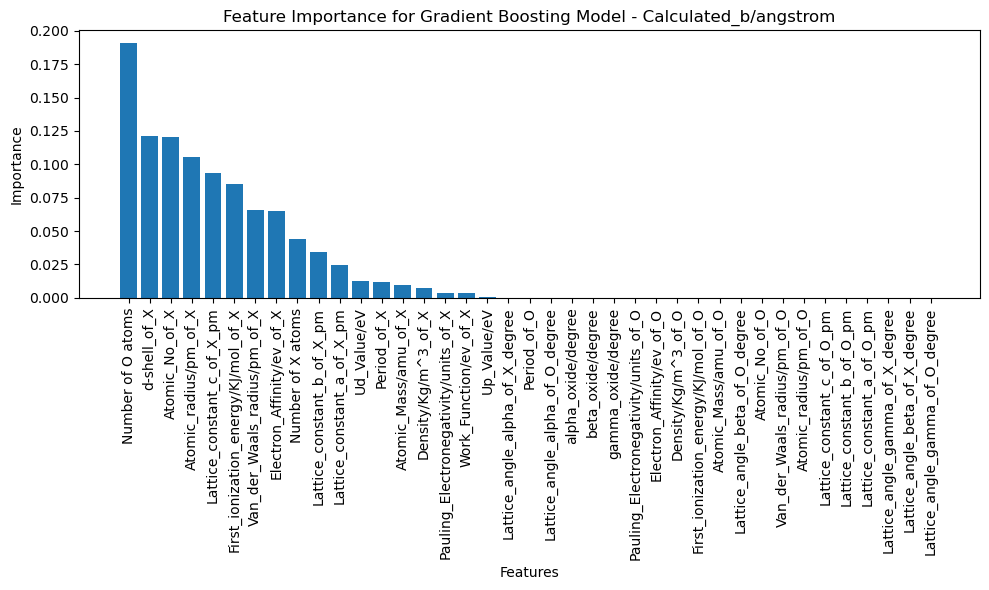

  Gradient Boosting model:
    Number of O atoms: 0.1908
    d-shell_of_X: 0.1213
    Atomic_No_of_X: 0.1204
    Atomic_radius/pm_of_X: 0.1054
    Lattice_constant_c_of_X_pm: 0.0935
    First_ionization_energy/KJ/mol_of_X: 0.0852
    Van_der_Waals_radius/pm_of_X: 0.0654
    Electron_Affinity/ev_of_X: 0.0649
    Number of X atoms: 0.0441
    Lattice_constant_b_of_X_pm: 0.0343
    Lattice_constant_a_of_X_pm: 0.0244
    Ud_Value/eV: 0.0126
    Period_of_X: 0.0121
    Atomic_Mass/amu_of_X: 0.0099
    Density/Kg/m^3_of_X: 0.0077
    Pauling_Electronegativity/units_of_X: 0.0037
    Work_Function/ev_of_X: 0.0033
    Up_Value/eV: 0.0009
    Lattice_angle_alpha_of_X_degree: 0.0000
    Period_of_O: 0.0000
    Lattice_angle_alpha_of_O_degree: 0.0000
    alpha_oxide/degree: 0.0000
    beta_oxide/degree: 0.0000
    gamma_oxide/degree: 0.0000
    Pauling_Electronegativity/units_of_O: 0.0000
    Electron_Affinity/ev_of_O: 0.0000
    Density/Kg/m^3_of_O: 0.0000
    First_ionization_energy/KJ/mol_of_O:

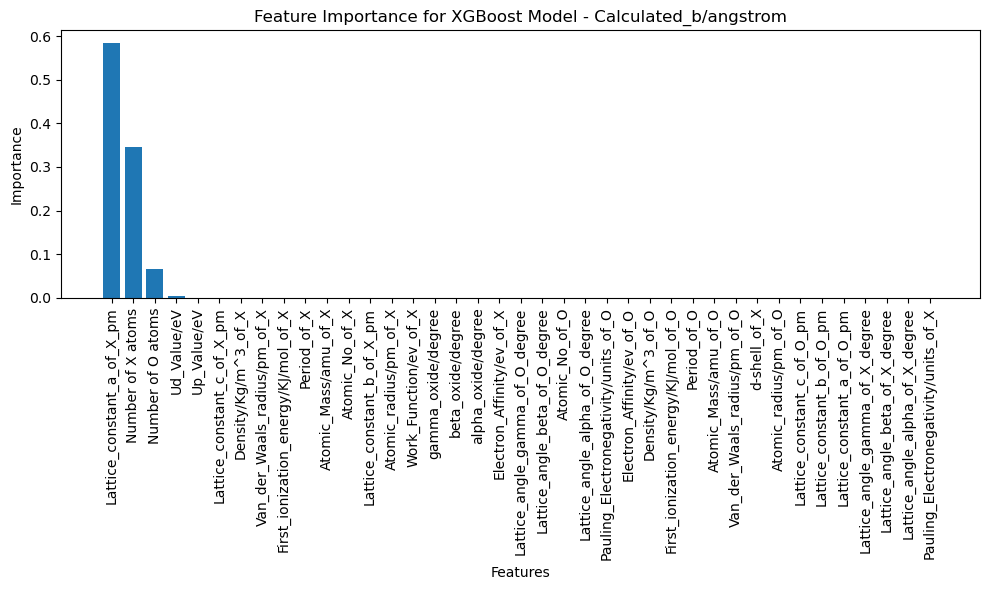

  XGBoost model:
    Lattice_constant_a_of_X_pm: 0.5841
    Number of X atoms: 0.3448
    Number of O atoms: 0.0666
    Ud_Value/eV: 0.0040
    Up_Value/eV: 0.0004
    Lattice_constant_c_of_X_pm: 0.0000
    Density/Kg/m^3_of_X: 0.0000
    Van_der_Waals_radius/pm_of_X: 0.0000
    First_ionization_energy/KJ/mol_of_X: 0.0000
    Period_of_X: 0.0000
    Atomic_Mass/amu_of_X: 0.0000
    Atomic_No_of_X: 0.0000
    Lattice_constant_b_of_X_pm: 0.0000
    Atomic_radius/pm_of_X: 0.0000
    Work_Function/ev_of_X: 0.0000
    gamma_oxide/degree: 0.0000
    beta_oxide/degree: 0.0000
    alpha_oxide/degree: 0.0000
    Electron_Affinity/ev_of_X: 0.0000
    Lattice_angle_gamma_of_O_degree: 0.0000
    Lattice_angle_beta_of_O_degree: 0.0000
    Atomic_No_of_O: 0.0000
    Lattice_angle_alpha_of_O_degree: 0.0000
    Pauling_Electronegativity/units_of_O: 0.0000
    Electron_Affinity/ev_of_O: 0.0000
    Density/Kg/m^3_of_O: 0.0000
    First_ionization_energy/KJ/mol_of_O: 0.0000
    Period_of_O: 0.0000
    At

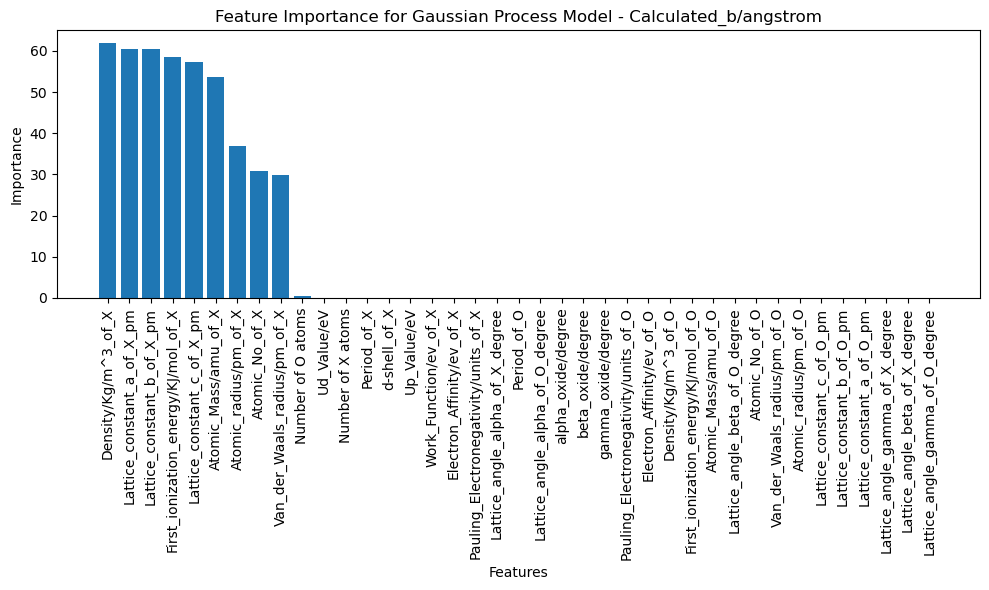

  Gaussian Process model:
    Density/Kg/m^3_of_X: 61.8934
    Lattice_constant_a_of_X_pm: 60.5285
    Lattice_constant_b_of_X_pm: 60.5285
    First_ionization_energy/KJ/mol_of_X: 58.5047
    Lattice_constant_c_of_X_pm: 57.3508
    Atomic_Mass/amu_of_X: 53.6010
    Atomic_radius/pm_of_X: 36.8220
    Atomic_No_of_X: 30.7978
    Van_der_Waals_radius/pm_of_X: 29.8539
    Number of O atoms: 0.3863
    Ud_Value/eV: 0.0269
    Number of X atoms: 0.0197
    Period_of_X: 0.0069
    d-shell_of_X: 0.0069
    Up_Value/eV: 0.0029
    Work_Function/ev_of_X: 0.0012
    Electron_Affinity/ev_of_X: 0.0000
    Pauling_Electronegativity/units_of_X: 0.0000
    Lattice_angle_alpha_of_X_degree: 0.0000
    Period_of_O: 0.0000
    Lattice_angle_alpha_of_O_degree: 0.0000
    alpha_oxide/degree: 0.0000
    beta_oxide/degree: 0.0000
    gamma_oxide/degree: 0.0000
    Pauling_Electronegativity/units_of_O: 0.0000
    Electron_Affinity/ev_of_O: 0.0000
    Density/Kg/m^3_of_O: 0.0000
    First_ionization_energy/KJ/m

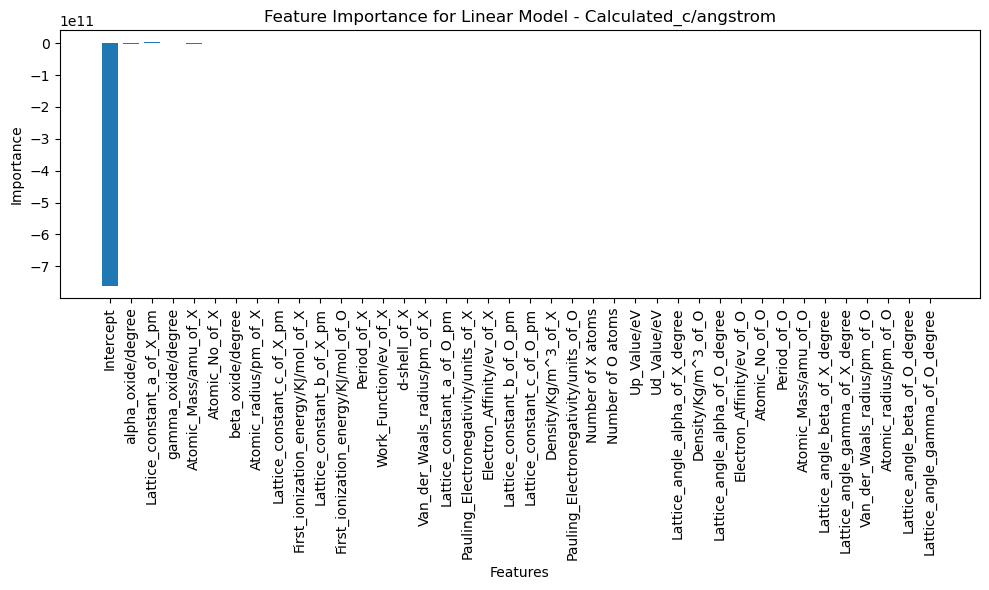

  Linear model:
    Intercept: -760534365745.8295
    alpha_oxide/degree: -2429329181.3294
    Lattice_constant_a_of_X_pm: 2025673419.0492
    gamma_oxide/degree: 1893888489.8836
    Atomic_Mass/amu_of_X: -1147458112.1060
    Atomic_No_of_X: -714291974.2158
    beta_oxide/degree: -435603191.7835
    Atomic_radius/pm_of_X: -433610158.0815
    Lattice_constant_c_of_X_pm: 381894613.4091
    First_ionization_energy/KJ/mol_of_X: 336258304.5449
    Lattice_constant_b_of_X_pm: 198720825.9043
    First_ionization_energy/KJ/mol_of_O: -44621263.2742
    Period_of_X: -35444302.7584
    Work_Function/ev_of_X: 24925112.6469
    d-shell_of_X: -17198130.3366
    Van_der_Waals_radius/pm_of_X: -13674585.9096
    Lattice_constant_a_of_O_pm: -11155315.8186
    Pauling_Electronegativity/units_of_X: 10149318.1473
    Electron_Affinity/ev_of_X: -8506848.3446
    Lattice_constant_b_of_O_pm: -5577657.9093
    Lattice_constant_c_of_O_pm: 5577657.9093
    Density/Kg/m^3_of_X: -2307637.9392
    Pauling_Electrone

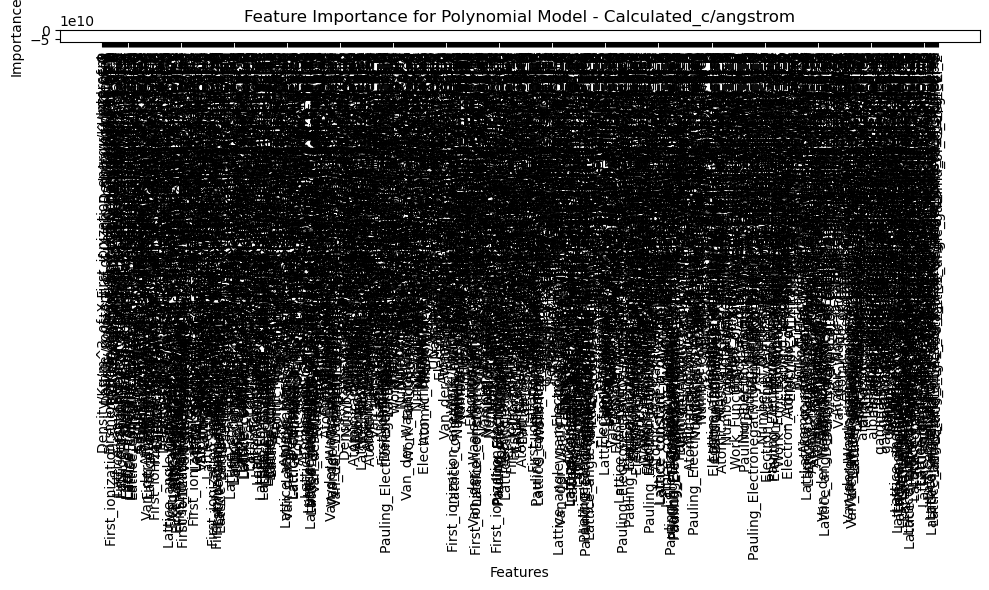

  Polynomial model:
    Intercept: -61904966275.4284
    1: -84635.9112
    Density/Kg/m^3_of_X First_ionization_energy/KJ/mol_of_O: 11663.4098
    alpha_oxide/degree: 11634.3909
    Lattice_constant_c_of_X_pm Density/Kg/m^3_of_X: 6937.0817
    Ud_Value/eV: 5758.9729
    Density/Kg/m^3_of_X Lattice_constant_a_of_O_pm: 4428.1998
    Up_Value/eV: -4364.6437
    First_ionization_energy/KJ/mol_of_O^2: 3297.9170
    First_ionization_energy/KJ/mol_of_O Density/Kg/m^3_of_O: -3102.0011
    First_ionization_energy/KJ/mol_of_X First_ionization_energy/KJ/mol_of_O: 3059.3886
    Lattice_constant_b_of_X_pm Density/Kg/m^3_of_X: -2966.3954
    Lattice_constant_a_of_X_pm Density/Kg/m^3_of_X: -2966.3954
    Density/Kg/m^3_of_X Density/Kg/m^3_of_O: 2710.0402
    Atomic_Mass/amu_of_X Density/Kg/m^3_of_X: -2176.0706
    Density/Kg/m^3_of_X^2: -1983.7336
    Density/Kg/m^3_of_X Lattice_constant_c_of_O_pm: -1976.2355
    Lattice_constant_c_of_X_pm First_ionization_energy/KJ/mol_of_X: 1783.8993
    First_ion

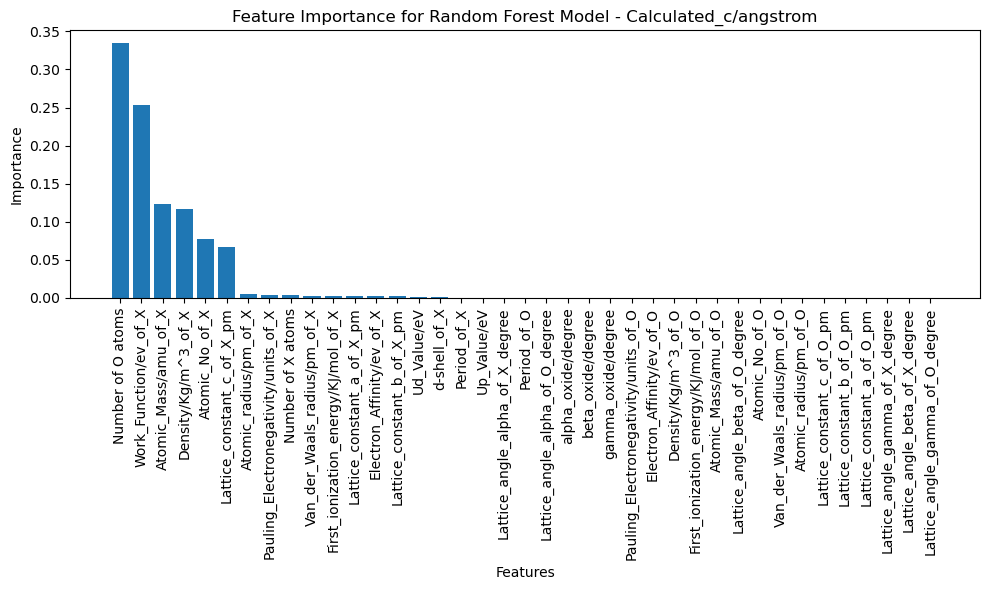

  Random Forest model:
    Number of O atoms: 0.3347
    Work_Function/ev_of_X: 0.2539
    Atomic_Mass/amu_of_X: 0.1237
    Density/Kg/m^3_of_X: 0.1173
    Atomic_No_of_X: 0.0772
    Lattice_constant_c_of_X_pm: 0.0666
    Atomic_radius/pm_of_X: 0.0046
    Pauling_Electronegativity/units_of_X: 0.0042
    Number of X atoms: 0.0034
    Van_der_Waals_radius/pm_of_X: 0.0029
    First_ionization_energy/KJ/mol_of_X: 0.0026
    Lattice_constant_a_of_X_pm: 0.0025
    Electron_Affinity/ev_of_X: 0.0025
    Lattice_constant_b_of_X_pm: 0.0022
    Ud_Value/eV: 0.0010
    d-shell_of_X: 0.0005
    Period_of_X: 0.0001
    Up_Value/eV: 0.0001
    Lattice_angle_alpha_of_X_degree: 0.0000
    Period_of_O: 0.0000
    Lattice_angle_alpha_of_O_degree: 0.0000
    alpha_oxide/degree: 0.0000
    beta_oxide/degree: 0.0000
    gamma_oxide/degree: 0.0000
    Pauling_Electronegativity/units_of_O: 0.0000
    Electron_Affinity/ev_of_O: 0.0000
    Density/Kg/m^3_of_O: 0.0000
    First_ionization_energy/KJ/mol_of_O: 0.0

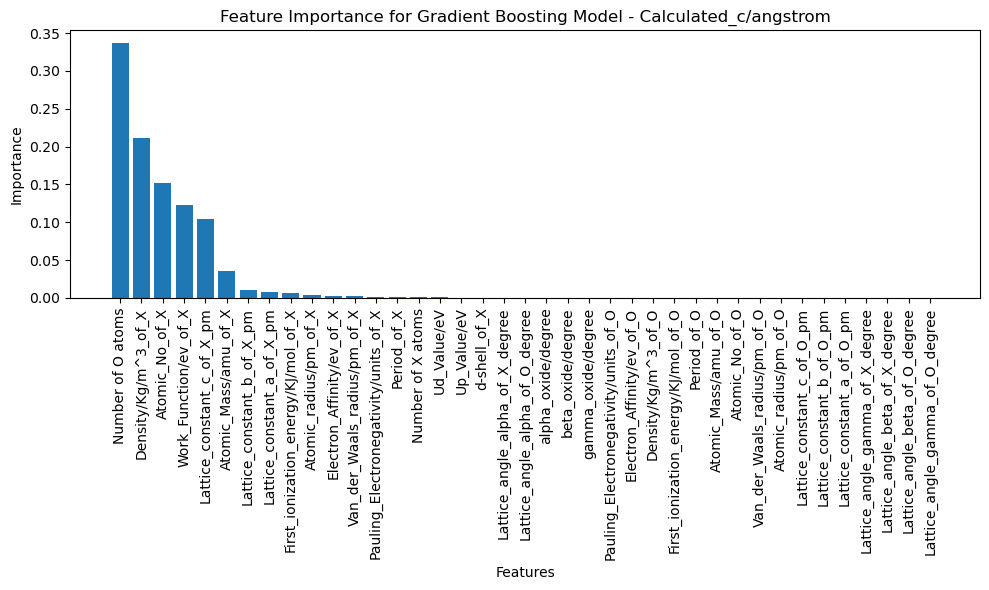

  Gradient Boosting model:
    Number of O atoms: 0.3369
    Density/Kg/m^3_of_X: 0.2120
    Atomic_No_of_X: 0.1519
    Work_Function/ev_of_X: 0.1225
    Lattice_constant_c_of_X_pm: 0.1041
    Atomic_Mass/amu_of_X: 0.0351
    Lattice_constant_b_of_X_pm: 0.0104
    Lattice_constant_a_of_X_pm: 0.0083
    First_ionization_energy/KJ/mol_of_X: 0.0070
    Atomic_radius/pm_of_X: 0.0035
    Electron_Affinity/ev_of_X: 0.0022
    Van_der_Waals_radius/pm_of_X: 0.0019
    Pauling_Electronegativity/units_of_X: 0.0016
    Period_of_X: 0.0012
    Number of X atoms: 0.0008
    Ud_Value/eV: 0.0007
    Up_Value/eV: 0.0001
    d-shell_of_X: 0.0000
    Lattice_angle_alpha_of_X_degree: 0.0000
    Lattice_angle_alpha_of_O_degree: 0.0000
    alpha_oxide/degree: 0.0000
    beta_oxide/degree: 0.0000
    gamma_oxide/degree: 0.0000
    Pauling_Electronegativity/units_of_O: 0.0000
    Electron_Affinity/ev_of_O: 0.0000
    Density/Kg/m^3_of_O: 0.0000
    First_ionization_energy/KJ/mol_of_O: 0.0000
    Period_of_O:

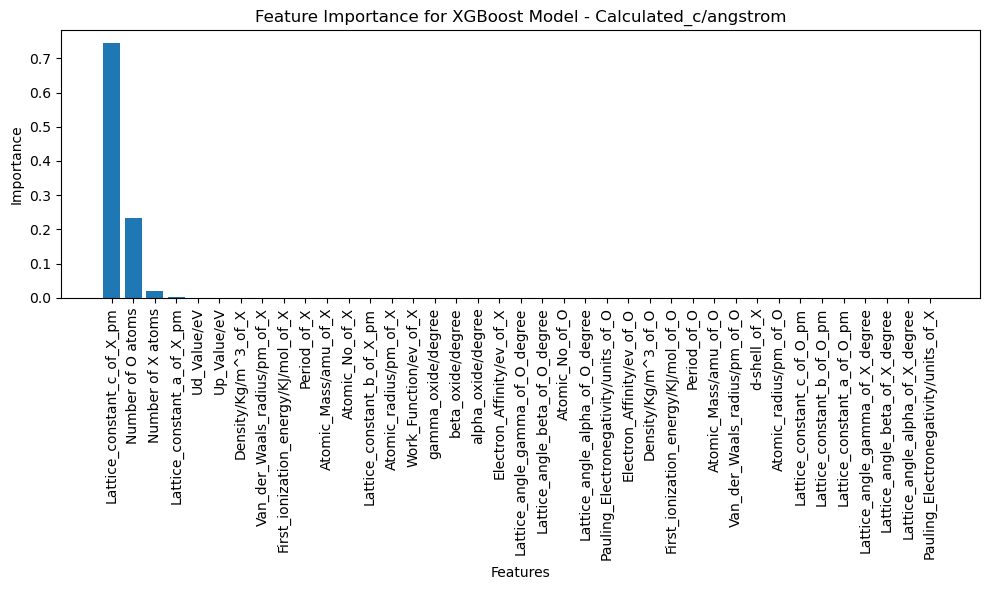

  XGBoost model:
    Lattice_constant_c_of_X_pm: 0.7446
    Number of O atoms: 0.2329
    Number of X atoms: 0.0205
    Lattice_constant_a_of_X_pm: 0.0020
    Ud_Value/eV: 0.0000
    Up_Value/eV: 0.0000
    Density/Kg/m^3_of_X: 0.0000
    Van_der_Waals_radius/pm_of_X: 0.0000
    First_ionization_energy/KJ/mol_of_X: 0.0000
    Period_of_X: 0.0000
    Atomic_Mass/amu_of_X: 0.0000
    Atomic_No_of_X: 0.0000
    Lattice_constant_b_of_X_pm: 0.0000
    Atomic_radius/pm_of_X: 0.0000
    Work_Function/ev_of_X: 0.0000
    gamma_oxide/degree: 0.0000
    beta_oxide/degree: 0.0000
    alpha_oxide/degree: 0.0000
    Electron_Affinity/ev_of_X: 0.0000
    Lattice_angle_gamma_of_O_degree: 0.0000
    Lattice_angle_beta_of_O_degree: 0.0000
    Atomic_No_of_O: 0.0000
    Lattice_angle_alpha_of_O_degree: 0.0000
    Pauling_Electronegativity/units_of_O: 0.0000
    Electron_Affinity/ev_of_O: 0.0000
    Density/Kg/m^3_of_O: 0.0000
    First_ionization_energy/KJ/mol_of_O: 0.0000
    Period_of_O: 0.0000
    At

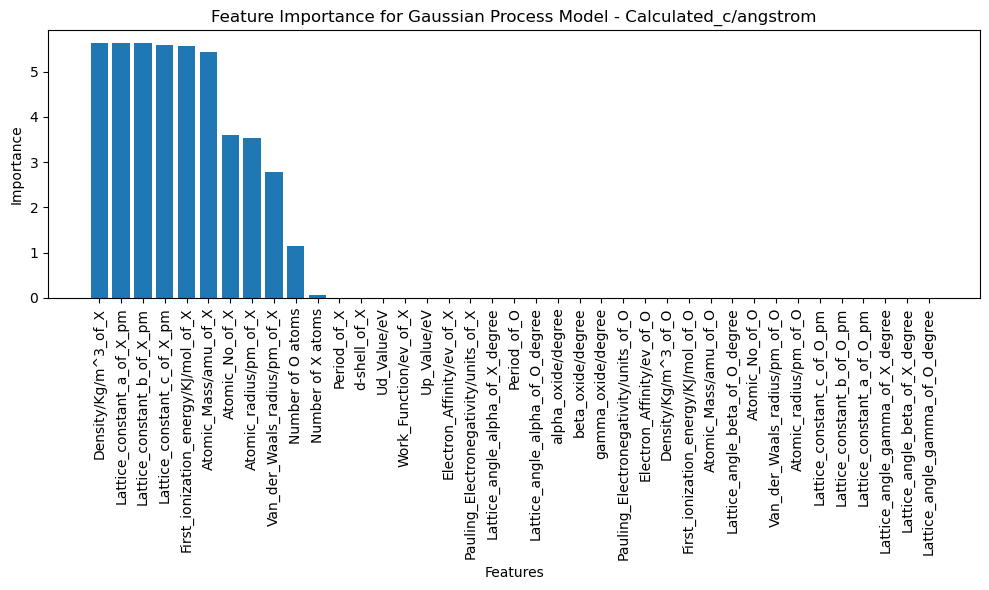

  Gaussian Process model:
    Density/Kg/m^3_of_X: 5.6282
    Lattice_constant_a_of_X_pm: 5.6254
    Lattice_constant_b_of_X_pm: 5.6254
    Lattice_constant_c_of_X_pm: 5.5946
    First_ionization_energy/KJ/mol_of_X: 5.5540
    Atomic_Mass/amu_of_X: 5.4228
    Atomic_No_of_X: 3.5870
    Atomic_radius/pm_of_X: 3.5349
    Van_der_Waals_radius/pm_of_X: 2.7887
    Number of O atoms: 1.1421
    Number of X atoms: 0.0707
    Period_of_X: 0.0025
    d-shell_of_X: 0.0025
    Ud_Value/eV: 0.0018
    Work_Function/ev_of_X: 0.0005
    Up_Value/eV: 0.0002
    Electron_Affinity/ev_of_X: 0.0000
    Pauling_Electronegativity/units_of_X: 0.0000
    Lattice_angle_alpha_of_X_degree: 0.0000
    Period_of_O: 0.0000
    Lattice_angle_alpha_of_O_degree: 0.0000
    alpha_oxide/degree: 0.0000
    beta_oxide/degree: 0.0000
    gamma_oxide/degree: 0.0000
    Pauling_Electronegativity/units_of_O: 0.0000
    Electron_Affinity/ev_of_O: 0.0000
    Density/Kg/m^3_of_O: 0.0000
    First_ionization_energy/KJ/mol_of_O: 

In [3]:
def evaluate_models(models, X_train, y_train, X_test, y_test):
    evaluation_results = {target: {} for target in y_train.columns}
    model_data = {target: {} for target in y_train.columns}
    
    for target in y_train.columns:
        for name, model in models.items():
            # Create a deep copy of the model for each target
            model_copy = clone(model)
            model_copy.fit(X_train, y_train[target])
            y_train_pred = model_copy.predict(X_train)
            y_test_pred = model_copy.predict(X_test)

            train_metrics = calculate_metrics(y_train[target], y_train_pred)
            test_metrics = calculate_metrics(y_test[target], y_test_pred)
            
            evaluation_results[target][name] = {
                'train_metrics': train_metrics,
                'test_metrics': test_metrics
            }
            
            model_data[target][name] = {
                'model': model_copy,
                'test_actuals': y_test[target],
                'test_predictions': y_test_pred
            }

    return evaluation_results, model_data

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred) if len(y_true) > 1 else np.nan
    return {
        'mse': mse,
        'rmse': np.sqrt(mse),
        'mae': mae,
        'r2': r2
    }

def plot_scatter_(ax, y_test, y_test_pred):
    scatter = ax.scatter(y_test, y_test_pred, color='brown', alpha=0.6, label='Extrapolation')
    #scatter = ax.scatter(y_test, y_test_pred, color='brown', alpha=0.6, label='m-ZrO₂')
    
    all_vals = np.concatenate([y_test, y_test_pred])
    min_val, max_val = np.min(all_vals), np.max(all_vals)
    buffer = (max_val - min_val) * 0.05
    
    ax.plot([min_val - buffer, max_val + buffer], [min_val - buffer, max_val + buffer], 'k--', lw=2)
    ax.set_xlim([min_val - buffer, max_val + buffer])
    ax.set_ylim([min_val - buffer, max_val + buffer])
    
    return scatter

def plot_model_results(sorted_evaluation_results, X, y, model_data):
    num_targets = len(y.columns)
    num_models = len(sorted_evaluation_results[y.columns[0]])
    fig, axes = plt.subplots(nrows=num_targets, ncols=num_models, figsize=(num_models * 5, num_targets * 5))
    
    if num_targets == 1:
        axes = [axes]
    if num_models == 1:
        axes = [[ax] for ax in axes]

    model_abbreviations = {
        'Linear': 'LR',
        'Random Forest': 'RFR',
        'Gradient Boosting': 'GBR',
        'XGBoost': 'XGBR',
        'Gaussian Process': 'GPR',
        'Polynomial': 'PR'
    }
    
    target_labels = {
        'Calculated_Band_Gap/eV': ('rPBE band gap (eV)', 'ML band gap (eV)'),
        #'Calculated_a/angstrom': ('rPBE a ≡ b ≡ c (Å)', 'ML a ≡ b ≡ c (Å)'),
        'Calculated_a/angstrom': ('rPBE a ≡ b (Å)', 'ML a ≡ b (Å)'),
        #'Calculated_a/angstrom': ('rPBE a (Å)', 'ML a (Å)'),
        'Calculated_b/angstrom': ('rPBE b (Å)', 'ML b (Å)'),
        'Calculated_c/angstrom': ('rPBE c (Å)', 'ML c (Å)')
    }

    for target_index, target in enumerate(y.columns):
        for model_index, (name, _) in enumerate(sorted_evaluation_results[target]):
            ax = axes[target_index][model_index]
            data = model_data[target][name]
            
            scatter = plot_scatter_(ax, data['test_actuals'], data['test_predictions'])
            
            model_abbr = model_abbreviations.get(name, name)
            alphabet_label = chr(103 + model_index)  # 103 is the ASCII code for 'g'
            #alphabet_label = chr(97 + model_index)  # 97 is the ASCII code for 'a'
            ax.set_title(f'({alphabet_label}). {model_abbr}', fontsize=18, weight='bold')
            
            x_label, y_label = target_labels.get(target, ('rPBE', 'ML Predicted'))
            ax.set_xlabel(x_label, fontsize=18, weight='bold')
            ax.set_ylabel(y_label, fontsize=18, weight='bold')
            
            ax.set_aspect('equal', adjustable='box')
            ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
            ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
            ax.tick_params(axis='both', which='major', labelsize=16)
            
            for label in ax.get_xticklabels() + ax.get_yticklabels():
                label.set_fontweight('bold')
            
            ax.legend(handles=[scatter], prop={'size': 12, 'weight': 'bold'}, loc='upper left')
    
    plt.tight_layout()
    plt.show()

def display_feature_importance(X_train, X_test, y_train, y_test, model_data):
    for target in y_train.columns:
        print(f"\nFeature importance for {target}:")
        for name, data in model_data[target].items():
            model = data['model']
            
            if name == 'Gaussian Process':
                # Perform permutation importance for GPR
                perm_importance = permutation_importance(model, X_test, y_test[target], n_repeats=30, random_state=100)
                feature_names = X_test.columns
                importance = perm_importance.importances_mean
            elif name == 'Polynomial':
                poly = model.named_steps['poly']
                regressor = model.named_steps['regressor']
                feature_names = ['Intercept'] + list(poly.get_feature_names_out(X_test.columns))
                importance = np.concatenate(([regressor.intercept_], regressor.coef_))
            elif name == 'Linear':
                regressor = model.named_steps['regressor']
                feature_names = ['Intercept'] + list(X_test.columns)
                importance = np.concatenate(([regressor.intercept_], regressor.coef_))
            elif hasattr(model.named_steps['regressor'], 'feature_importances_'):
                importance = model.named_steps['regressor'].feature_importances_
                feature_names = X_test.columns
            elif hasattr(model.named_steps['regressor'], 'coef_'):
                importance = np.concatenate(([model.named_steps['regressor'].intercept_], model.named_steps['regressor'].coef_))
                feature_names = ['Intercept'] + list(X_test.columns)
            else:
                print(f"  {name} model does not support feature importance extraction.")
                continue

            # Sort features by importance
            sorted_idx = np.argsort(np.abs(importance))[::-1]
            sorted_features = np.array(feature_names)[sorted_idx]
            sorted_importance = importance[sorted_idx]

            # Plot feature importance
            plt.figure(figsize=(10, 6))
            plt.bar(range(len(sorted_importance)), sorted_importance, align='center')
            plt.xticks(range(len(sorted_importance)), sorted_features, rotation=90)
            plt.xlabel('Features')
            plt.ylabel('Importance')
            plt.title(f'Feature Importance for {name} Model - {target}')
            plt.tight_layout()
            plt.show()

            # Print feature importance
            print(f"  {name} model:")
            for feat, imp in zip(sorted_features, sorted_importance):
                print(f"    {feat}: {imp:.4f}")
            print()

# Load the training data
#train_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='All_Systems (-m-ZrO2)+ Extra')
#train_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='All_Systems + Extra')
#train_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='All_Primary_System')
train_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='All_Primary_System+Extra')

# Primary Oxides without Extrapolation Data
#train_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Rutile TiO2 Orig')
#train_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Anatase TiO2 Orig')
#train_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Cubic ZnO Orig')
#train_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Cubic ZnO2 Orig')
#train_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Cubic ZrO2 Orig')
#train_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Cubic CeO2 Orig')
#train_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='All_Primary_System')
#train_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='All_Primary_System+Extra')

# Load the test data
#test_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Rutile')

# Extrapolation Data Only
#test_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Rutile TiO2-Extra')
#test_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Anatase TiO2-Extra')
#test_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Cubic ZnO-Extra')
#test_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Cubic ZnO2-Extra')
#test_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Cubic ZrO2-Extra')
#test_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Cubic CeO2-Extra')

#test_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='All Extra')
#test_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='All_Primary_System')
test_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='All_Primary_System+Extra')
#test_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='All_Secondary_Systems')


#All available features
features = ["Up_Value/eV", "Ud_Value/eV", "alpha_oxide/degree", "beta_oxide/degree", "gamma_oxide/degree", "Number of X atoms", "Number of O atoms", "Lattice_constant_a_of_X_pm", "Lattice_constant_b_of_X_pm", "Lattice_constant_c_of_X_pm", "Atomic_radius/pm_of_X",  "Van_der_Waals_radius/pm_of_X", "Atomic_No_of_X", "Atomic_Mass/amu_of_X", "Period_of_X", "First_ionization_energy/KJ/mol_of_X", "Density/Kg/m^3_of_X", "Electron_Affinity/ev_of_X", "Work_Function/ev_of_X", "Pauling_Electronegativity/units_of_X", "d-shell_of_X", "Lattice_angle_alpha_of_X_degree", "Lattice_angle_beta_of_X_degree", "Lattice_angle_gamma_of_X_degree", "Lattice_constant_a_of_O_pm", "Lattice_constant_b_of_O_pm", "Lattice_constant_c_of_O_pm", "Atomic_radius/pm_of_O", "Van_der_Waals_radius/pm_of_O", "Atomic_No_of_O", "Atomic_Mass/amu_of_O", "Period_of_O", "First_ionization_energy/KJ/mol_of_O", "Density/Kg/m^3_of_O", "Electron_Affinity/ev_of_O", "Pauling_Electronegativity/units_of_O", "Lattice_angle_alpha_of_O_degree", "Lattice_angle_beta_of_O_degree", "Lattice_angle_gamma_of_O_degree"]

#features = ["Ud_Value/eV", "Up_Value/eV"]

targets = ['Calculated_Band_Gap/eV', 'Calculated_a/angstrom', 'Calculated_b/angstrom', 'Calculated_c/angstrom']

# Prepare training and test data
X_train = train_data[features]
y_train = train_data[targets]
X_test = test_data[features]
y_test = test_data[targets]

# Define models
models = {
    'Linear': Pipeline([('regressor', LinearRegression())]),
    'Polynomial': Pipeline([('poly', PolynomialFeatures(2)), ('regressor', LinearRegression())]),
    'Random Forest': Pipeline([('scaler', StandardScaler()), ('regressor', RandomForestRegressor(random_state=100))]),
    'Gradient Boosting': Pipeline([('scaler', StandardScaler()), ('regressor', GradientBoostingRegressor(random_state=100))]),
    'XGBoost': Pipeline([('scaler', StandardScaler()), ('regressor', XGBRegressor(random_state=100))]),
    'Gaussian Process': Pipeline([('regressor', GaussianProcessRegressor(kernel=RBF(), alpha=0.0001, random_state=100))]), 
    #'Ridge': Pipeline([('regressor', Ridge())]),
    #'Decision Tree': Pipeline([('scaler', StandardScaler()), ('regressor', DecisionTreeRegressor(random_state=100))])
}

# Perform evaluation
evaluation_results, model_data = evaluate_models(models, X_train, y_train, X_test, y_test)

# Sort models based on test MSE
sorted_evaluation_results = {target: sorted(evaluation_results[target].items(), 
                                            key=lambda x: x[1]['test_metrics']['mse']) 
                             for target in y_train.columns}

# Print model performance metrics
for target in y_train.columns:
    print(f"\nModel Performance Metrics for {target} (sorted by Test MSE):")
    for name, metrics in sorted_evaluation_results[target]:
        train = metrics['train_metrics']
        test = metrics['test_metrics']

        print(f"{name}:")
        print(f"  Train Metrics - MSE = {train['mse']:.2f}, RMSE = {train['rmse']:.2f}, "
              f"MAE = {train['mae']:.2f}, R2 = {train['r2']:.2f}")
        print(f"  Test Metrics - MSE = {test['mse']:.2f}, RMSE = {test['rmse']:.2f}, "
              f"MAE = {test['mae']:.2f}, R2 = {test['r2']:.2f}\n")

# Plot results
plot_model_results(sorted_evaluation_results, X_test, y_test, model_data)

# Display feature importance
display_feature_importance(X_train, X_test, y_train, y_test, model_data)

Feature Coefficients:
     1  Up_Value/eV  Ud_Value/eV  Up_Value/eV^2  Up_Value/eV Ud_Value/eV  \
0  0.0     0.011518     0.103939       0.001081                 0.002481   
1  0.0    -0.004105     0.004958      -0.000067                 0.000044   
2  0.0    -0.004105     0.004958      -0.000067                 0.000044   
3  0.0    -0.001461     0.013863      -0.000027                -0.000037   

   Ud_Value/eV^2  
0       0.001054  
1       0.000097  
2       0.000097  
3      -0.000173  
Intercepts:
[1.8195117  4.68688119 4.68688119 2.98473756]


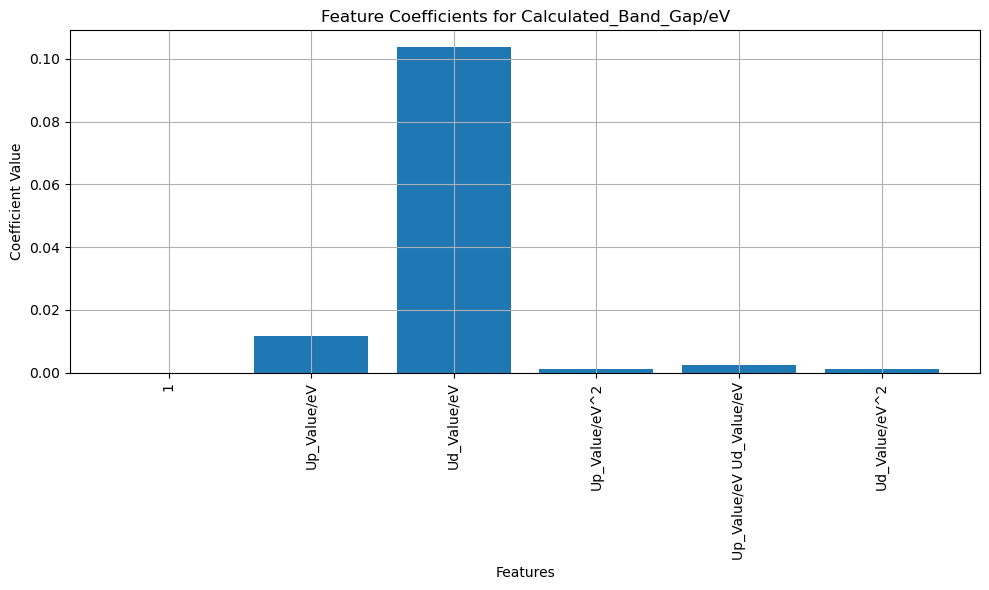

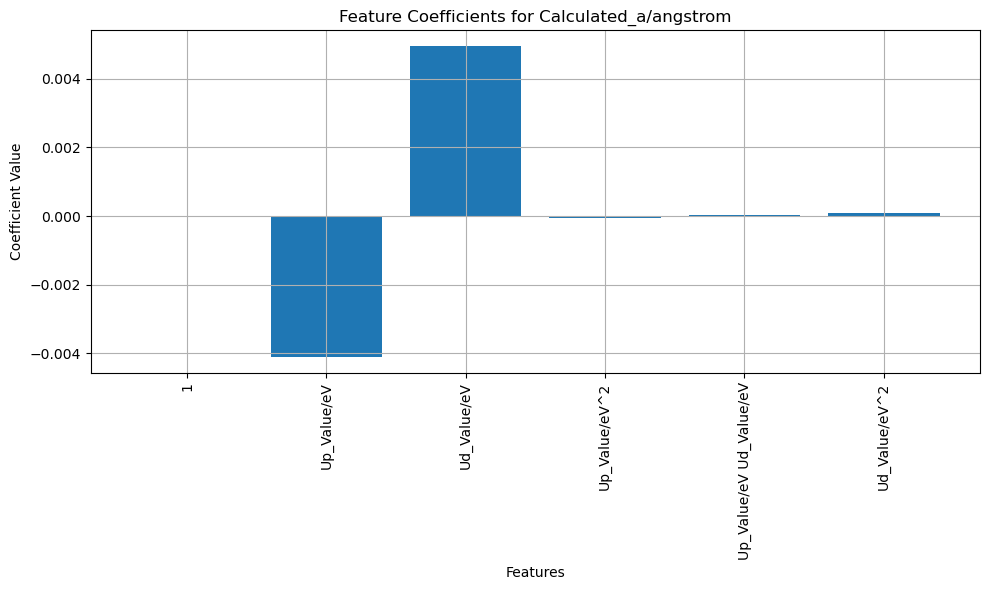

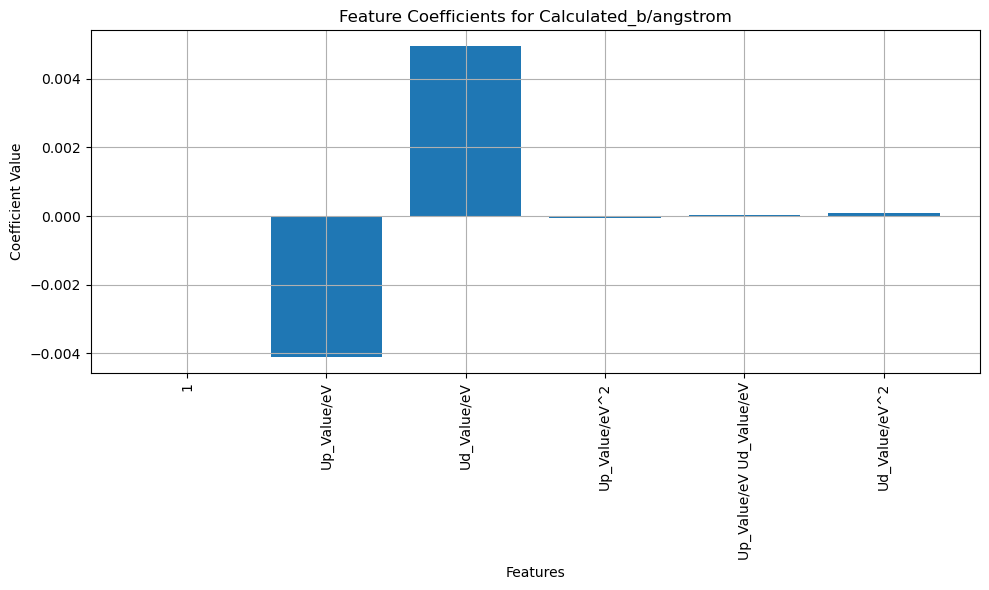

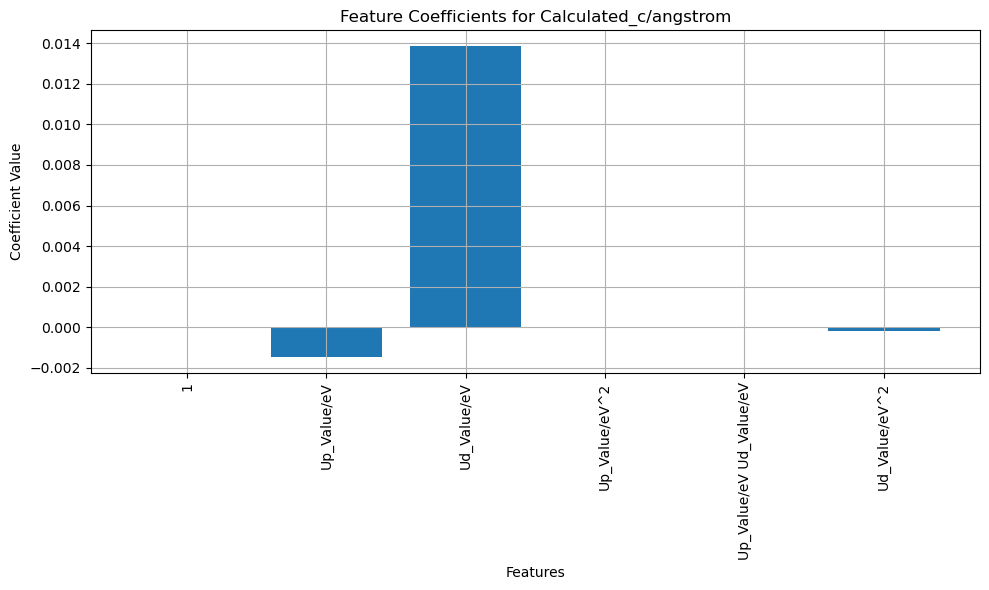


Original case (Both Up and Ud varying) results:
Up_Value/eV: 20.91, Ud_Value/eV: 3.12
Predicted values: Band Gap: 3.0300 eV, Lattice constant a: 4.5910 Å, Lattice constant b: 4.5910 Å, Lattice constant c: 2.9815 Å
Best loss: 0.0019511540
Percentage differences: Band Gap: 0.00%, Lattice constant a: -0.06%, Lattice constant b: -0.06%, Lattice constant c: 0.66%

Modified case (Up fixed to zero, Ud varying) results:
Up_Value/eV: 0.00, Ud_Value/eV: 10.52
Predicted values: Band Gap: 3.0298 eV, Lattice constant a: 4.7498 Å, Lattice constant b: 4.7498 Å, Lattice constant c: 3.1115 Å
Best loss: 0.0296408495
Percentage differences: Band Gap: -0.01%, Lattice constant a: 3.40%, Lattice constant b: 3.40%, Lattice constant c: 5.05%


In [7]:

def extract_feature_coefficients(model, feature_names):
    coefficients_list = []
    intercepts = []
    for estimator in model.estimators_:
        linear_regressor = estimator.named_steps['linearregression']
        poly_features = estimator.named_steps['polynomialfeatures']
        feature_names_poly = poly_features.get_feature_names_out(feature_names)
        coefficients = linear_regressor.coef_
        intercept = linear_regressor.intercept_
        coefficients_list.append(coefficients)
        intercepts.append(intercept)
    
    return pd.DataFrame(np.array(coefficients_list).reshape(len(model.estimators_), -1), columns=feature_names_poly), np.array(intercepts)

def plot_feature_coefficients(coefficients, intercept, target_names):
    for i, target in enumerate(target_names):
        plt.figure(figsize=(10, 6))
        plt.bar(coefficients.columns, coefficients.iloc[i])
        plt.title(f'Feature Coefficients for {target}')
        plt.xlabel('Features')
        plt.ylabel('Coefficient Value')
        plt.xticks(rotation=90)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def calculate_weighted_ape(predicted, experimental, weights):
    absolute_percentage_errors = np.abs((predicted - experimental) / experimental)
    weighted_absolute_percentage_errors = np.sum(weights * absolute_percentage_errors) / np.sum(weights) 
    return weighted_absolute_percentage_errors


# Define the search spaces, basically the lower and upper limit you are putting on U_p and U_d/f values. 
search_space_both = [
    Real(0.01, 40.00, name='up_value'),
    Real(0.01, 40.00, name='ud_value')
]

search_space_ud_only = [
    Real(0.01, 40.00, name='ud_value')
]

# Define the weights
#weights = np.array([1, 0, 0, 0])  # Emphasizing Band Gap more
weights = np.array([1, 1, 1, 1])  # Equal weights for all parameters

@use_named_args(search_space_both)
def objective_both(up_value, ud_value):
    X_new_temp = X_new.copy()
    X_new_temp['Up_Value/eV'] = up_value
    X_new_temp['Ud_Value/eV'] = ud_value
    
    y_pred = multi_target_model.predict(X_new_temp)
    loss = calculate_weighted_ape(y_pred, experimental_values, weights)
    return loss

@use_named_args(search_space_ud_only)
def objective_ud_only(ud_value):
    X_new_temp = X_new.copy()
    X_new_temp['Up_Value/eV'] = 0  # Fix Up to zero
    X_new_temp['Ud_Value/eV'] = ud_value
    
    y_pred = multi_target_model.predict(X_new_temp)
    loss = calculate_weighted_ape(y_pred, experimental_values, weights)
    return loss

def evaluate_and_print(result, case_name):
    if len(result.x) == 2:
        best_up_value, best_ud_value = result.x
    else:
        best_up_value, best_ud_value = 0, result.x[0]
    
    X_new_temp = X_new.copy()
    X_new_temp['Up_Value/eV'] = best_up_value
    X_new_temp['Ud_Value/eV'] = best_ud_value
    best_pred = multi_target_model.predict(X_new_temp)[0]
    
    percentage_differences = 100 * (best_pred - experimental_values) / experimental_values
    
    print(f"\n{case_name} results:")
    print(f"Up_Value/eV: {best_up_value:.2f}, Ud_Value/eV: {best_ud_value:.2f}")
    print(f"Predicted values: Band Gap: {best_pred[0]:.4f} eV, Lattice constant a: {best_pred[1]:.4f} Å, Lattice constant b: {best_pred[2]:.4f} Å, Lattice constant c: {best_pred[3]:.4f} Å")
    print(f"Best loss: {result.fun:.10f}")
    print(f"Percentage differences: Band Gap: {percentage_differences[0]:.2f}%, Lattice constant a: {percentage_differences[1]:.2f}%, Lattice constant b: {percentage_differences[2]:.2f}%, Lattice constant c: {percentage_differences[3]:.2f}%")

# This is the data you use in training the model. 
data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Rutile TiO2')
#data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Anatase TiO2')
#data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Cubic ZnO')
#data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Cubic ZnO2')
#data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Cubic ZrO2')
#data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Cubic CeO2')

# These are the features you use in training the model
features = ["Up_Value/eV", "Ud_Value/eV"]

X = data[features]
y = data[['Calculated_Band_Gap/eV', 'Calculated_a/angstrom', 'Calculated_b/angstrom', 'Calculated_c/angstrom']]

pr_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
multi_target_model = MultiOutputRegressor(pr_model)
multi_target_model.fit(X, y)

coefficients, intercept = extract_feature_coefficients(multi_target_model, features)
print("Feature Coefficients:")
print(coefficients)
print("Intercepts:")
print(intercept)

target_names = ['Calculated_Band_Gap/eV', 'Calculated_a/angstrom', 'Calculated_b/angstrom', 'Calculated_c/angstrom']
plot_feature_coefficients(coefficients, intercept, target_names)

# This sheet contains features of the metal oxide you are interested in. It is useful when trying to predict
new_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Rutile')
#new_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='Anatase')
#new_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='C-ZnO')
#new_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='C-ZnO2')
#new_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='C-ZrO2')
#new_data = pd.read_excel('rPBE Metal Oxides.xlsx', sheet_name='C-CeO2')
X_new = new_data[features]

# Get experimental values
# Rutile
exp_band_gap, exp_lattice_a, exp_lattice_b, exp_lattice_c = 3.03, 4.5937, 4.5937, 2.9618
# Anatase
#exp_band_gap, exp_lattice_a, exp_lattice_b, exp_lattice_c = 3.2, 3.78512, 3.78512, 9.51185
# Cubic ZnO
#exp_band_gap, exp_lattice_a, exp_lattice_b, exp_lattice_c = 3.37, 4.63, 4.63, 4.63
# Cubic ZnO2
#exp_band_gap, exp_lattice_a, exp_lattice_b, exp_lattice_c = 4.5, 4.871, 4.871, 4.871
# Cubic ZrO2
#exp_band_gap, exp_lattice_a, exp_lattice_b, exp_lattice_c = 4.6, 5.1189, 5.1189, 5.1189
# Cubic CeO2
#exp_band_gap, exp_lattice_a, exp_lattice_b, exp_lattice_c = 3.2, 5.411, 5.411, 5.411

experimental_values = np.array([exp_band_gap, exp_lattice_a, exp_lattice_b, exp_lattice_c])

# Perform Bayesian Optimization for both cases
result_both = gp_minimize(objective_both, search_space_both, n_calls=200, random_state=100)
result_ud_only = gp_minimize(objective_ud_only, search_space_ud_only, n_calls=50, random_state=100)

# Evaluate and print results for both cases
evaluate_and_print(result_both, "Original case (Both Up and Ud varying)")
evaluate_and_print(result_ud_only, "Modified case (Up fixed to zero, Ud varying)")